# Anomaly Detection Pipeline – Converted from main.py

In [2]:
import os
import pandas as pd
from config import DEVICES_DATA_PATH, SAVED_MODELS_PATH, global_start_time, process, start_memory
from device_utils import get_device_files, get_model_name, get_numerical_features
from state_anomaly import detect_state_anomalies
# Removed imports for RF classifier (apply_random_forest, train_rf_for_device) as they belong to IC or are no longer used here
from plotting import plot_reconstruction_error # Only import the AD plot
from export_json import export_incident_json # Keep this to generate anomalies_output.json
import postgres_connection as pg_conn
import paho.mqtt.client as mqtt
import json
from datetime import datetime


In [3]:
# Define the process_device function using csv
def process_device(device_type : str, csv_file_path : str): # Changed parameter name to csv_file_path for clarity
    """
    Process a device's data and apply anomaly detection.
    """
    print(f"\n{'=' * 50}")
    print(f"Processing device: {device_type}")
    print(f"{'=' * 50}\n")

    device_start_time = pd.Timestamp.now()
    df_all = pd.DataFrame() # This will collect processed data from all states

    try:
        df = pd.read_csv(csv_file_path) # csv_file_path is already a full path
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        available_features = get_numerical_features(df)

        if not available_features:
            print(f"⚠️ {device_type} - No numeric features detected.")
            return None

        print(f"{device_type} - Auto-detected features: {available_features}")

        # Process each state using LSTM
        for state in df['state'].unique():
            model_name = get_model_name(device_type, state)
            model_path = os.path.join(SAVED_MODELS_PATH, model_name)

            if not os.path.exists(model_path):
                print(f"⚠️ Missing model for {device_type} state: {state}")
                continue

            df_state = df[df['state'] == state].copy()
            df_processed = detect_state_anomalies(df_state, model_path, available_features)

            # Concatenate processed state data, only if it has reconstruction_error
            if 'reconstruction_error' in df_processed.columns:
                df_all = pd.concat([df_all, df_processed], ignore_index=True)
            else:
                print(f"⚠️ {device_type} - State {state} processed, but 'reconstruction_error' column is missing. Skipping concatenation.")


        if df_all.empty:
            print(f"⚠️ {device_type} - No data processed for any state. Skipping further steps.")
            return None

        df_all.sort_values('timestamp', inplace=True)
        df_all.reset_index(drop=True, inplace=True)

        # Removed RF classifier application (as it's part of IC or removed)
        # df_all = apply_random_forest(df_all, device_type)

        # --- DEBUG: is_anomaly counts BEFORE JSON export ---
        print(f"\n--- DEBUG: {device_type} is_anomaly counts BEFORE JSON export ---")
        if 'is_anomaly' in df_all.columns:
            print(df_all['is_anomaly'].value_counts())
        else:
            print("'is_anomaly' column not found in df_all!")
        print("--------------------------------------------------")

        # ✅ Only plot reconstruction error
        # This function should be in the plotting.py of the AD repo
        plot_reconstruction_error(df_all, device_type, "All States")

        # ✅ Export JSON output for downstream systems
        # This will now export all processed data points (with error and is_anomaly)
        export_incident_json(df_all, device_type)


        print(f"✅ Finished {device_type} in {(pd.Timestamp.now() - device_start_time).total_seconds():.2f} sec")
        return df_all

    except Exception as e:
        print(f"❌ Error processing {device_type}: {str(e)}")
        import traceback # Import traceback here for debugging
        traceback.print_exc() # Print full traceback for debugging
        return None
    
# Define the process_device function using query result 

def process_device_query(device_type: str, df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Process a device's time-series DataFrame and apply anomaly detection.

    Parameters:
    - device_type: device name (used for model naming, plots, etc.)
    - df_raw: time-series DataFrame (e.g., from get_motor_timeseries)
    """
    print(f"\n{'=' * 50}")
    print(f"Processing device: {device_type}")
    print(f"{'=' * 50}\n")

    device_start_time = pd.Timestamp.now()
    df_all = pd.DataFrame()

    try:
        df = df_raw.copy()
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        available_features = get_numerical_features(df)

        if not available_features:
            print(f"⚠️ {device_type} - No numeric features detected.")
            return None

        print(f"{device_type} - Auto-detected features: {available_features}")

        for state in df['state'].unique():
            model_name = get_model_name(device_type, state)
            model_path = os.path.join(SAVED_MODELS_PATH, model_name)

            if not os.path.exists(model_path):
                print(f"⚠️ Missing model for {device_type} state: {state}")
                continue

            df_state = df[df['state'] == state].copy()
            df_processed = detect_state_anomalies(df_state, model_path, available_features)

            if 'reconstruction_error' in df_processed.columns:
                df_all = pd.concat([df_all, df_processed], ignore_index=True)
            else:
                print(f"⚠️ {device_type} - State {state} processed, but 'reconstruction_error' column is missing.")

        if df_all.empty:
            print(f"⚠️ {device_type} - No data processed for any state.")
            return None

        df_all.sort_values('timestamp', inplace=True)
        df_all.reset_index(drop=True, inplace=True)

        print(f"\n--- DEBUG: {device_type} is_anomaly counts BEFORE JSON export ---")
        if 'is_anomaly' in df_all.columns:
            print(df_all['is_anomaly'].value_counts())
        else:
            print("'is_anomaly' column not found in df_all!")

        plot_reconstruction_error(df_all, device_type, "All States")
        export_incident_json(df_all, device_type)

        print(f"✅ Finished {device_type} in {(pd.Timestamp.now() - device_start_time).total_seconds():.2f} sec")
        return df_all

    except Exception as e:
        print(f"❌ Error processing {device_type}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


/tmp/ipykernel_13/1364803145.py:35: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  mqtt_client = mqtt.Client(client_id="prediction-publisher")
/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
2025-06-27 03:19:57.960088: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.316772 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 4

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    634
True       4
Name: count, dtype: int64


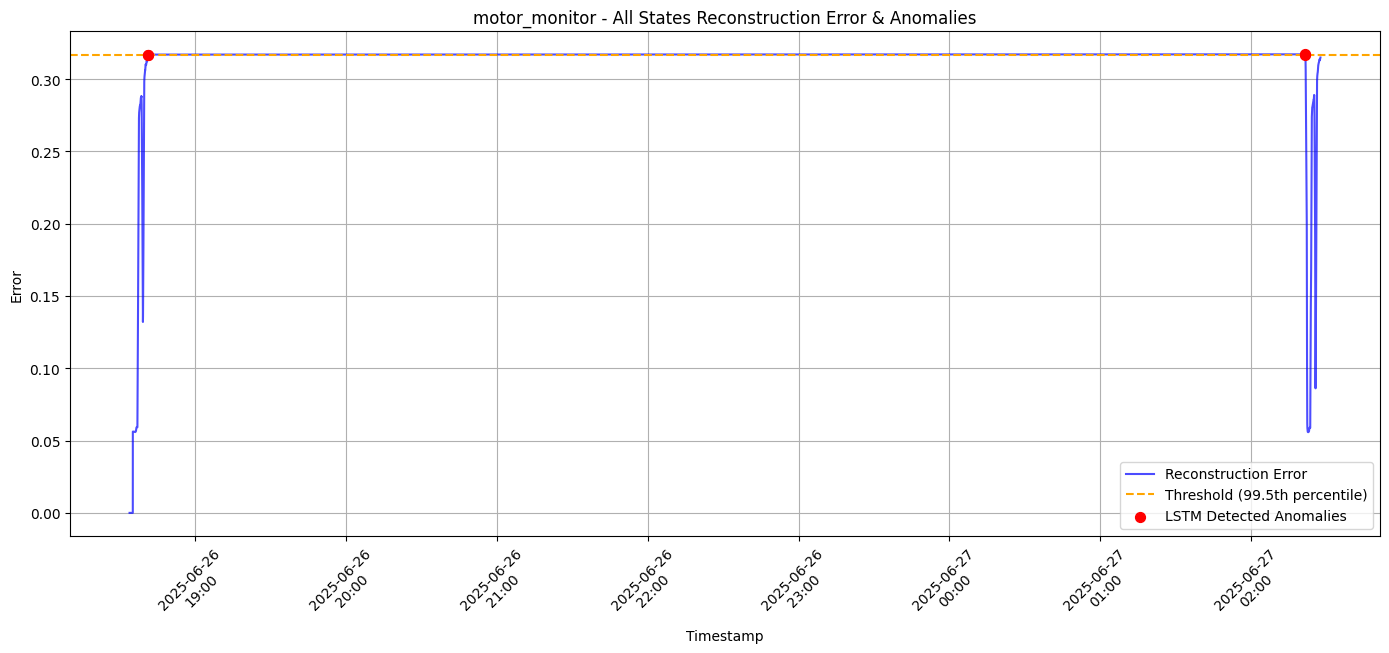

📤 Exported 638 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.03 sec
📤 prediction/anomaly/motor1 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.311766 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    446
True       3
Name: count, dtype: int64


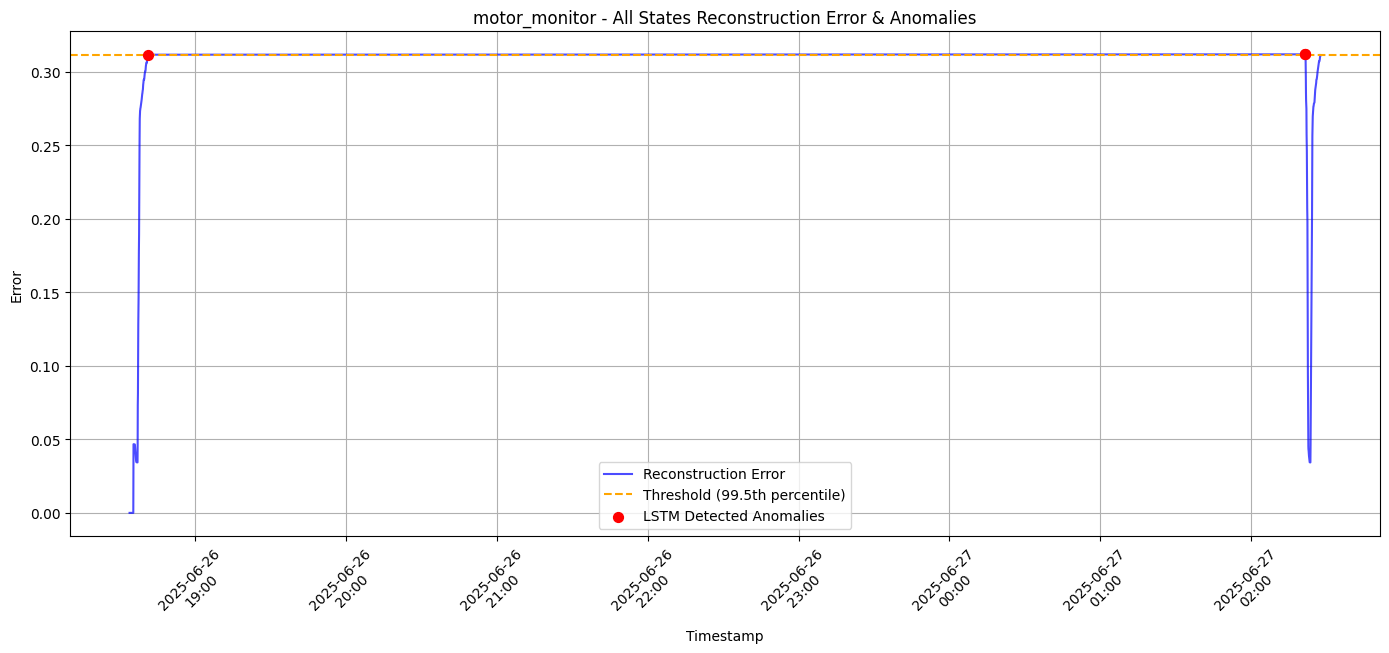

📤 Exported 449 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.01 sec
📤 prediction/anomaly/motor10 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.308477 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    604
True       3
Name: count, dtype: int64


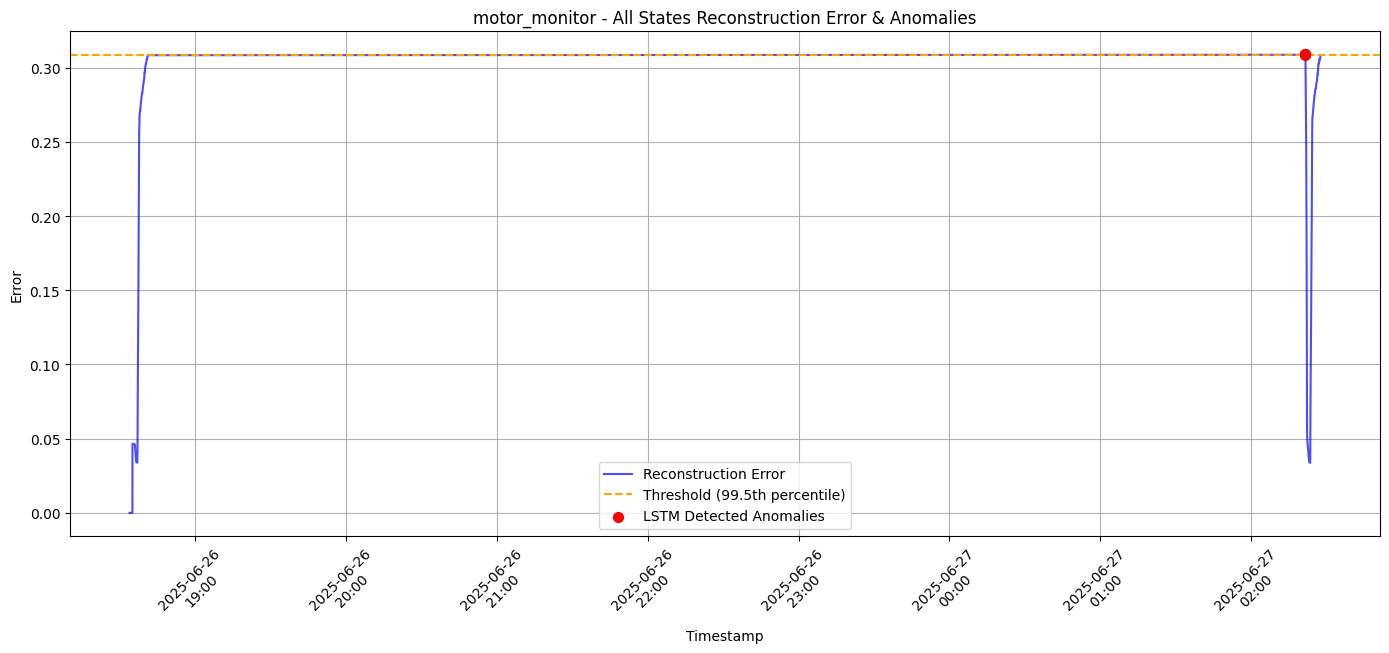

📤 Exported 607 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.43 sec
📤 prediction/anomaly/motor11 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.310234 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    588
True       3
Name: count, dtype: int64


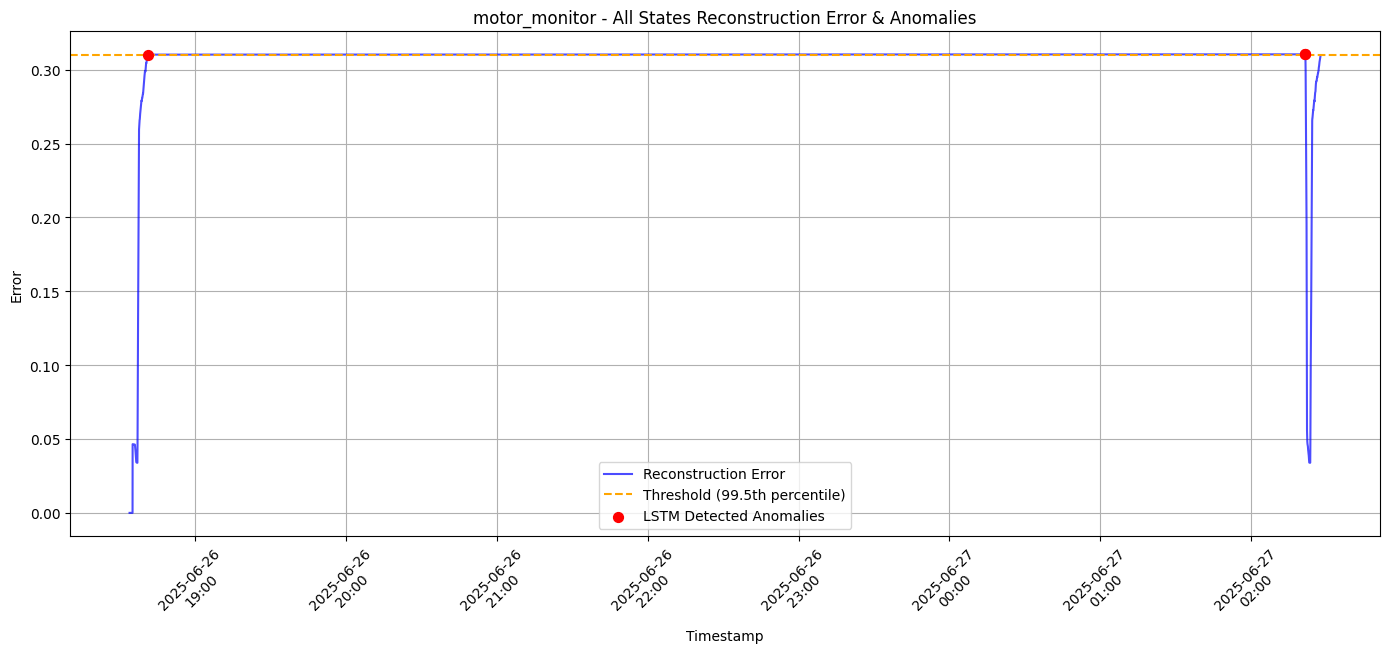

📤 Exported 591 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.11 sec
📤 prediction/anomaly/motor12 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.314028 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    601
True       3
Name: count, dtype: int64


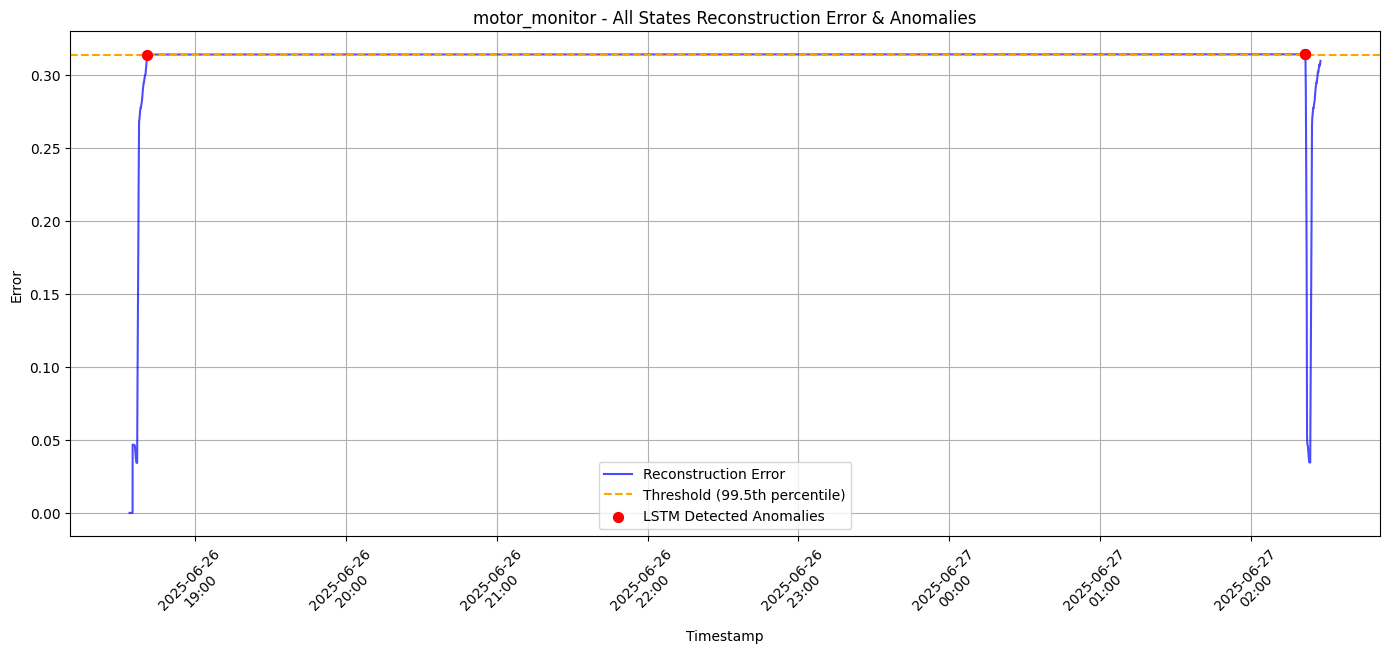

📤 Exported 604 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.10 sec
📤 prediction/anomaly/motor13 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.316689 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    571
True       3
Name: count, dtype: int64


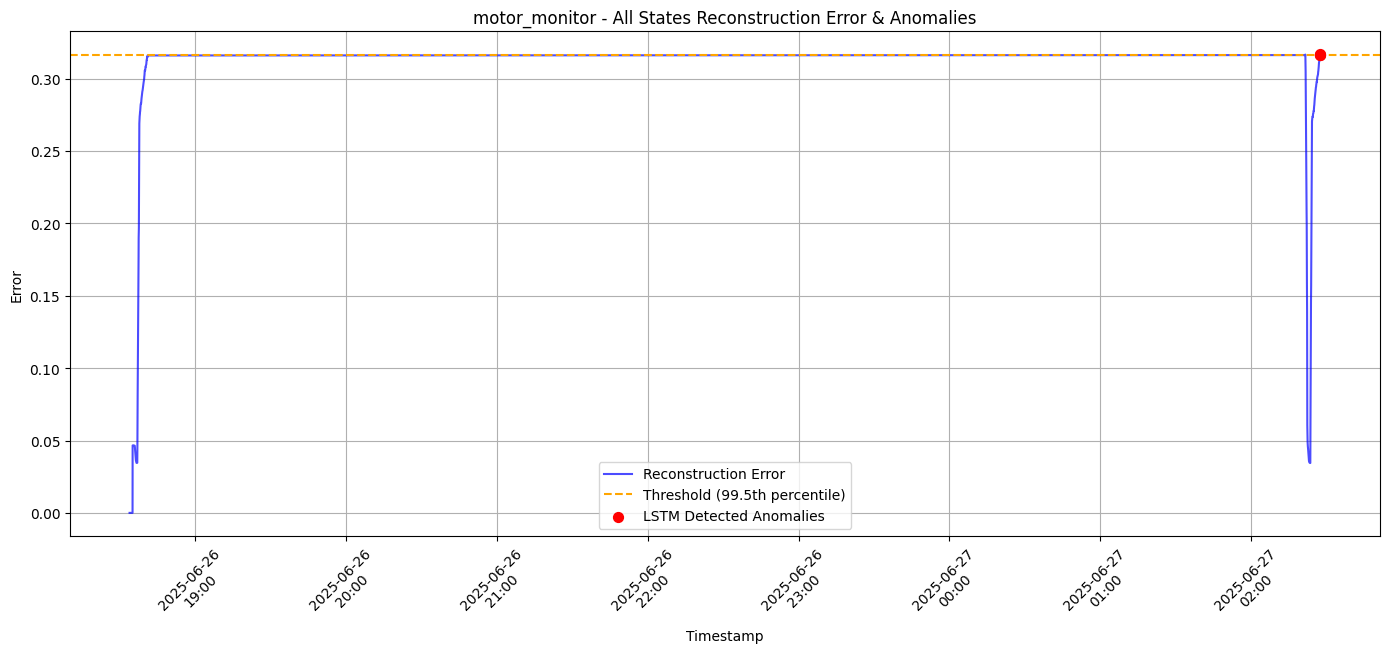

📤 Exported 574 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.75 sec
📤 prediction/anomaly/motor14 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.314844 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    581
True       3
Name: count, dtype: int64


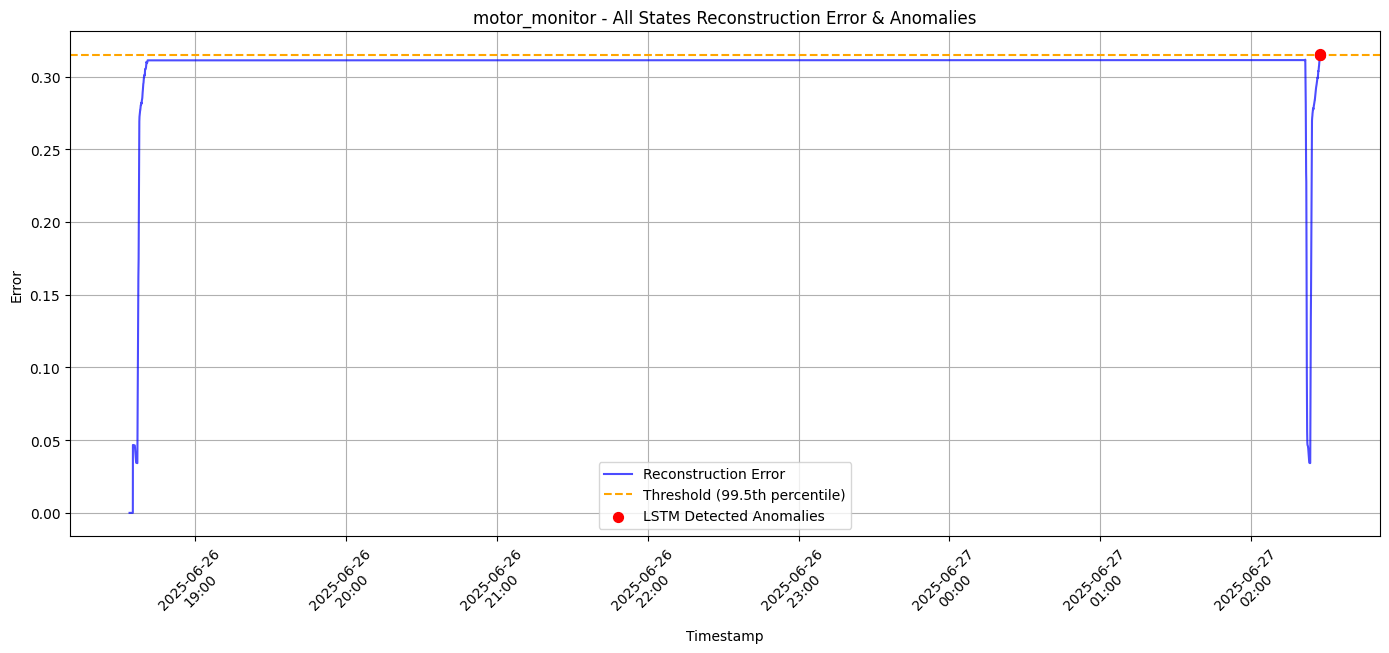

📤 Exported 584 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.26 sec
📤 prediction/anomaly/motor15 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.312930 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    527
True       3
Name: count, dtype: int64


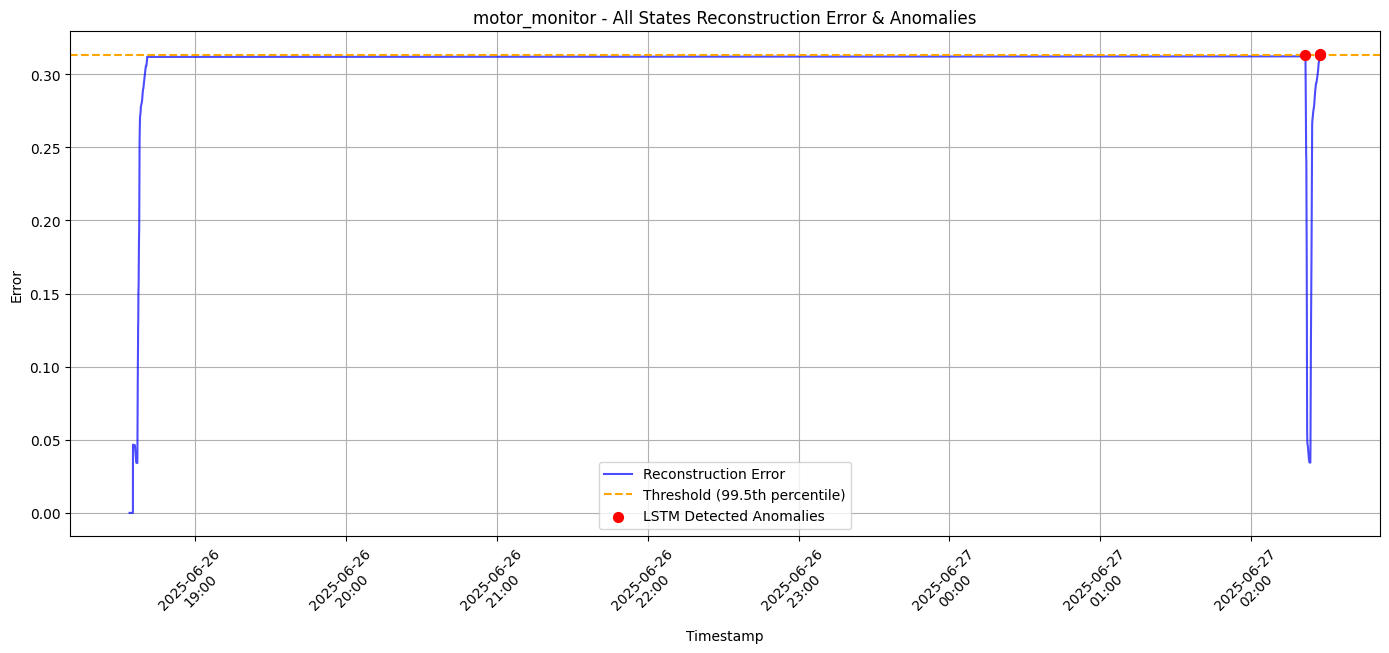

📤 Exported 530 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.92 sec
📤 prediction/anomaly/motor16 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.310632 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    501
True       3
Name: count, dtype: int64


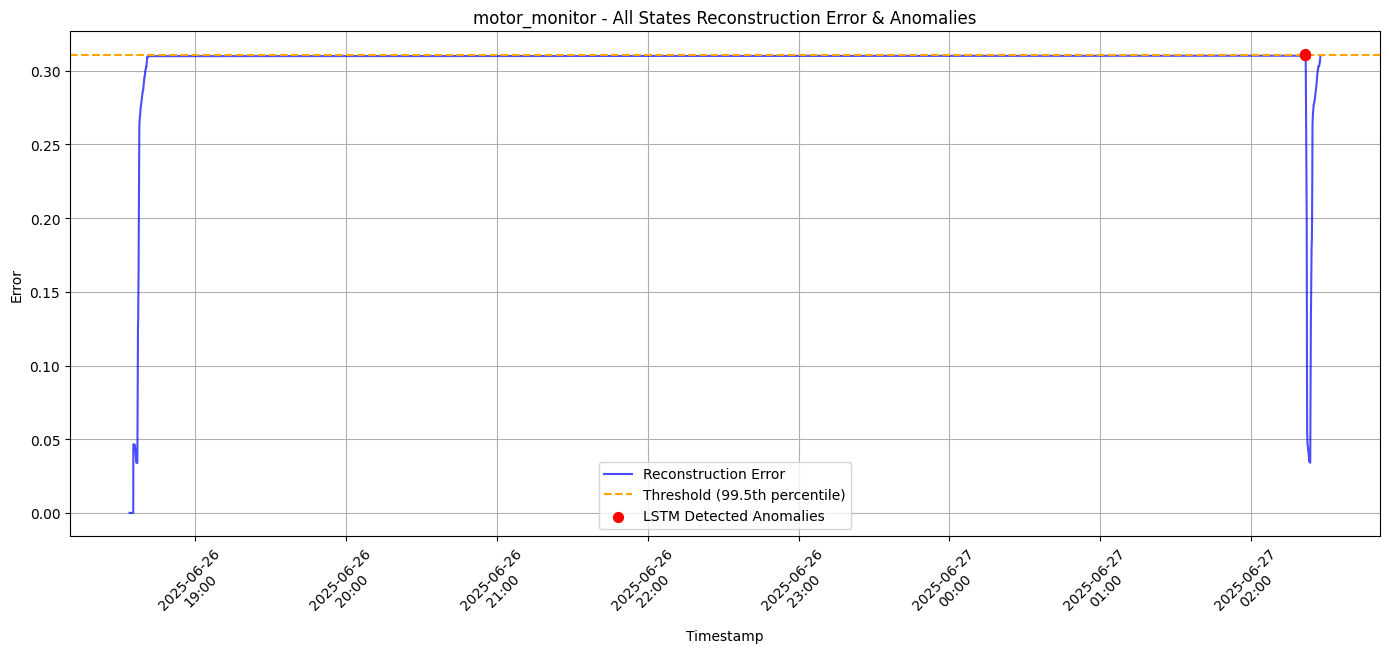

📤 Exported 504 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.96 sec
📤 prediction/anomaly/motor17 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.316576 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    466
True       3
Name: count, dtype: int64


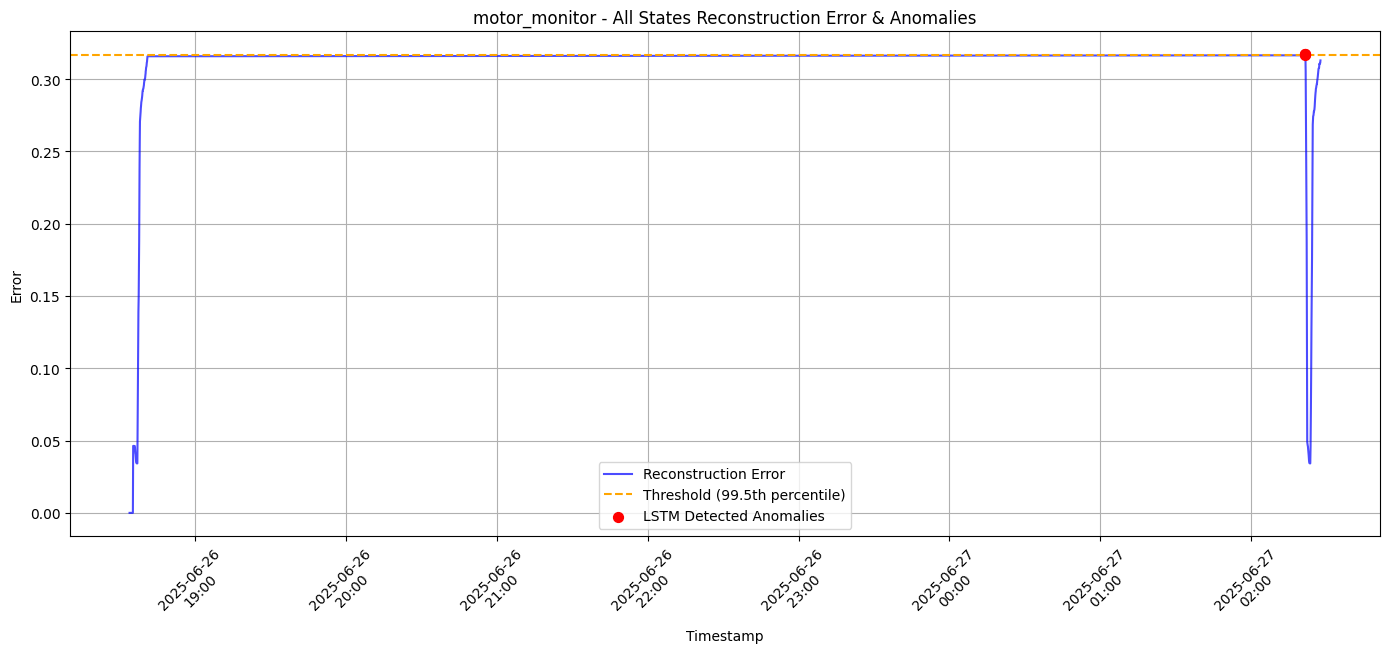

📤 Exported 469 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.91 sec
📤 prediction/anomaly/motor18 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.310003 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    445
True       3
Name: count, dtype: int64


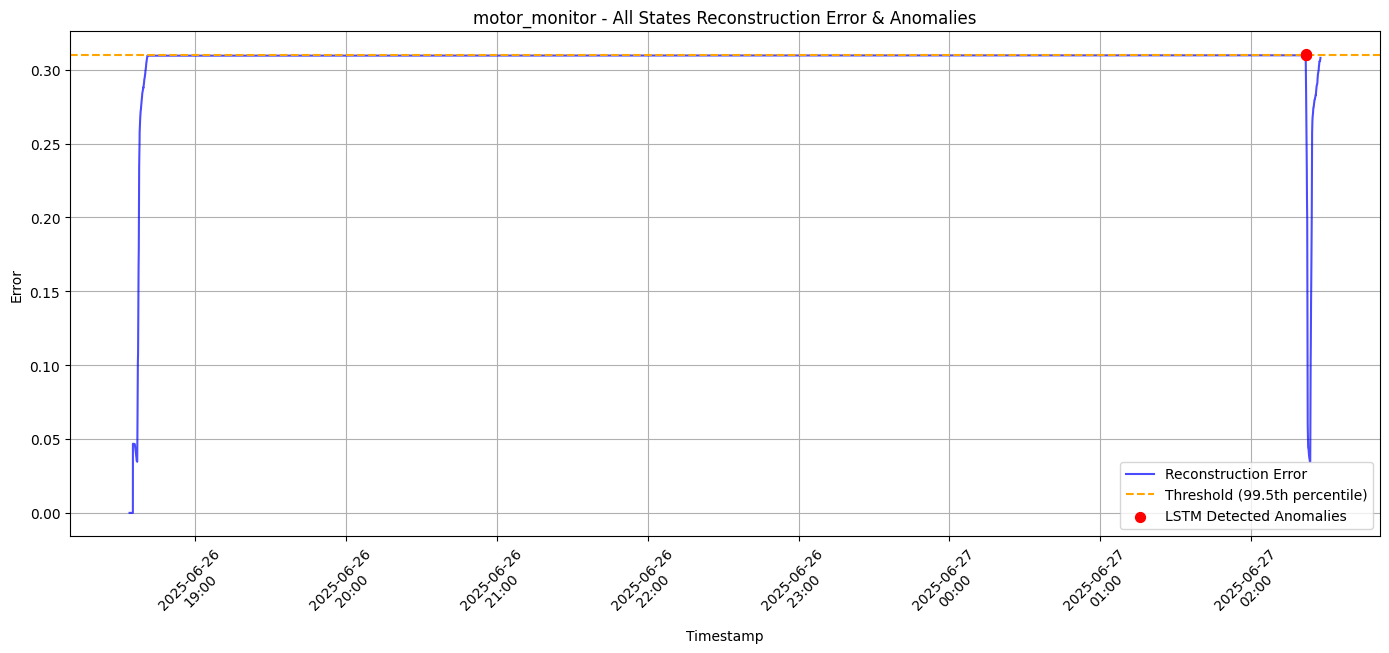

📤 Exported 448 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.90 sec
📤 prediction/anomaly/motor19 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
❌ Error processing motor_monitor: local variable 'batch_outputs' referenced before assignment

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
2025-06-27 03:20:09.594425: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/tmp/ipykernel_13/1294906939.py", line 116, in process_device_query
    df_processed = detect_state_anomalies(df_state, model_path, available_features)
  File "/app/src/pip

Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.315404 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    456
True       3
Name: count, dtype: int64


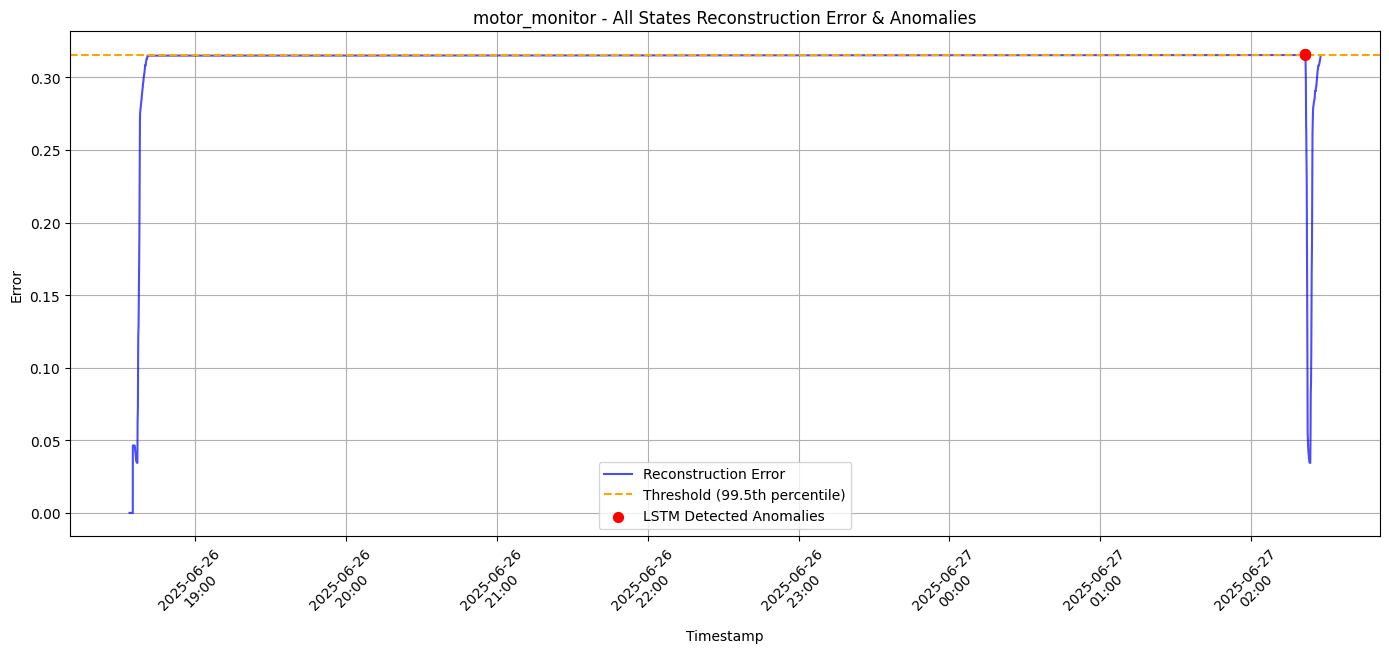

📤 Exported 459 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.93 sec
📤 prediction/anomaly/motor20 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.309095 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    461
True       3
Name: count, dtype: int64


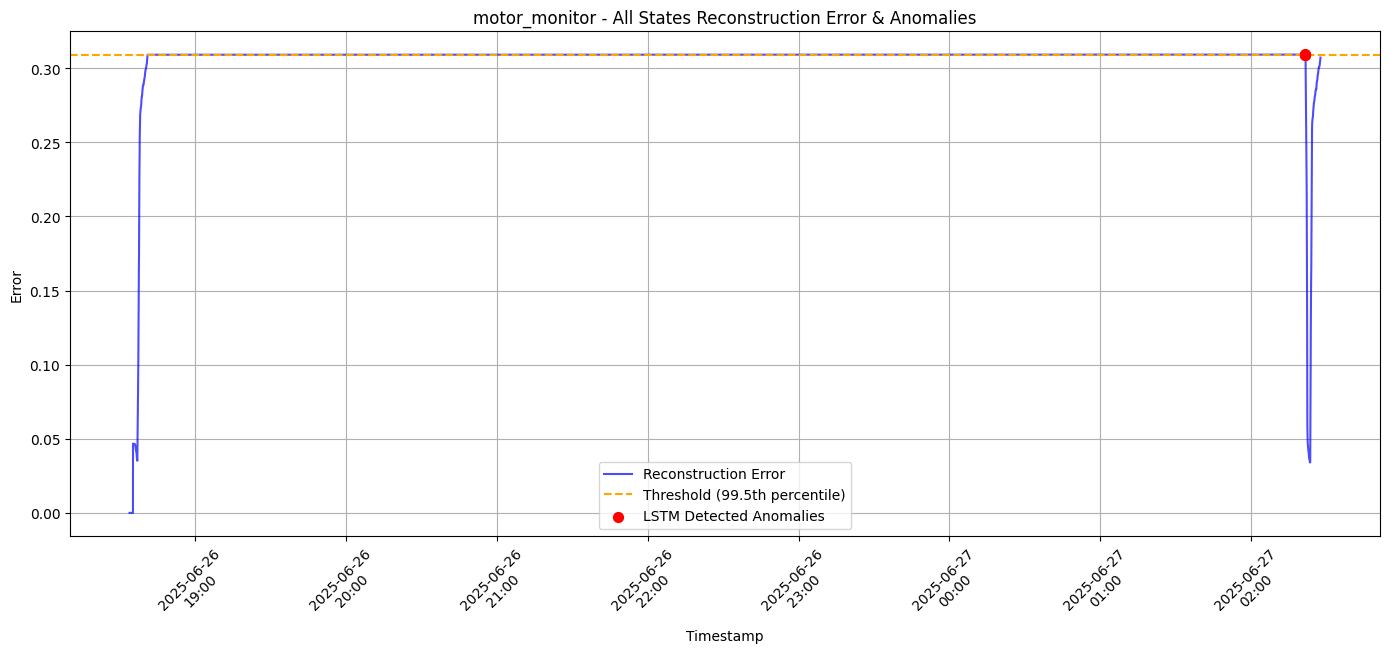

📤 Exported 464 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.93 sec
📤 prediction/anomaly/motor21 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.311208 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    452
True       3
Name: count, dtype: int64


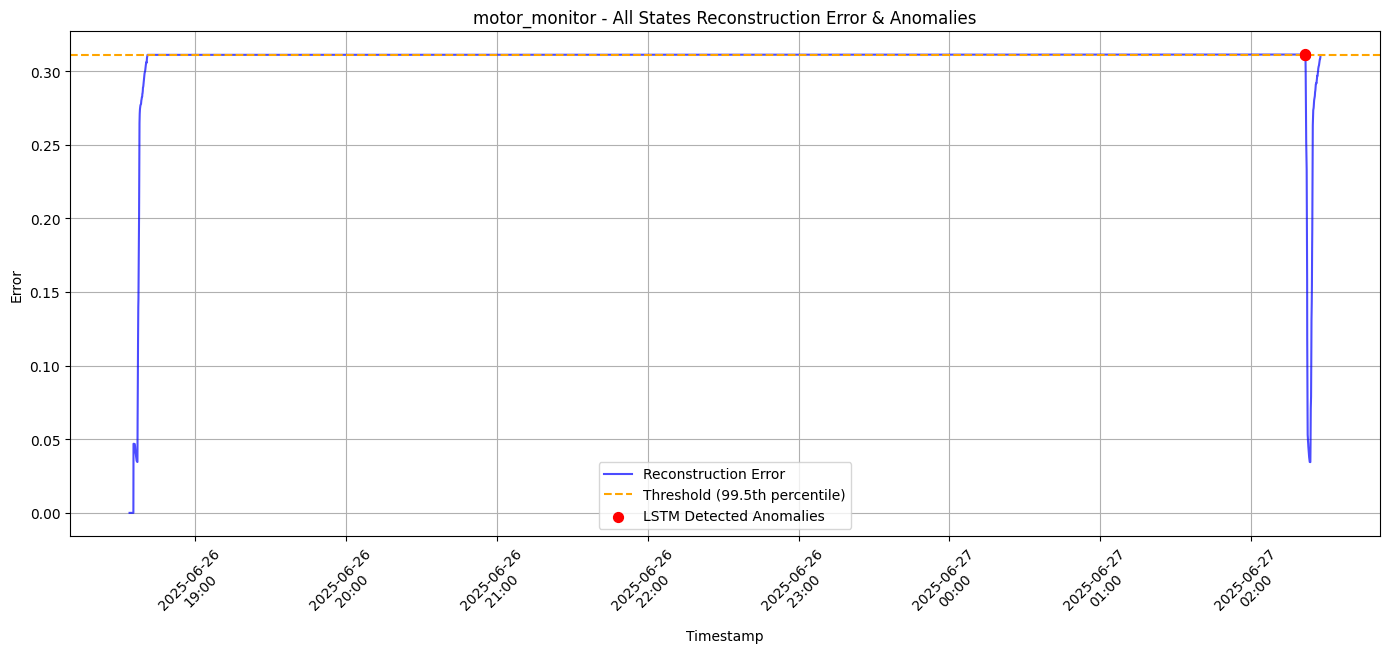

📤 Exported 455 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.16 sec
📤 prediction/anomaly/motor22 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.315012 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    455
True       3
Name: count, dtype: int64


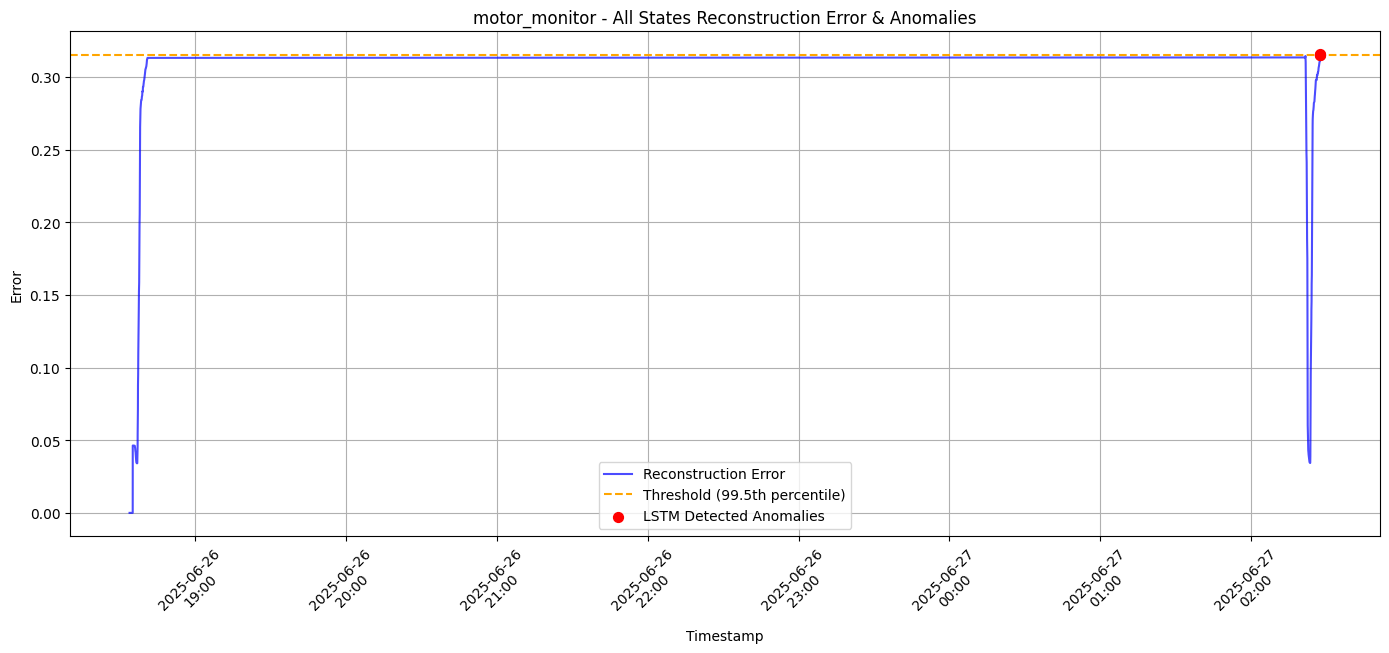

📤 Exported 458 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.95 sec
📤 prediction/anomaly/motor23 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.307409 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    464
True       3
Name: count, dtype: int64


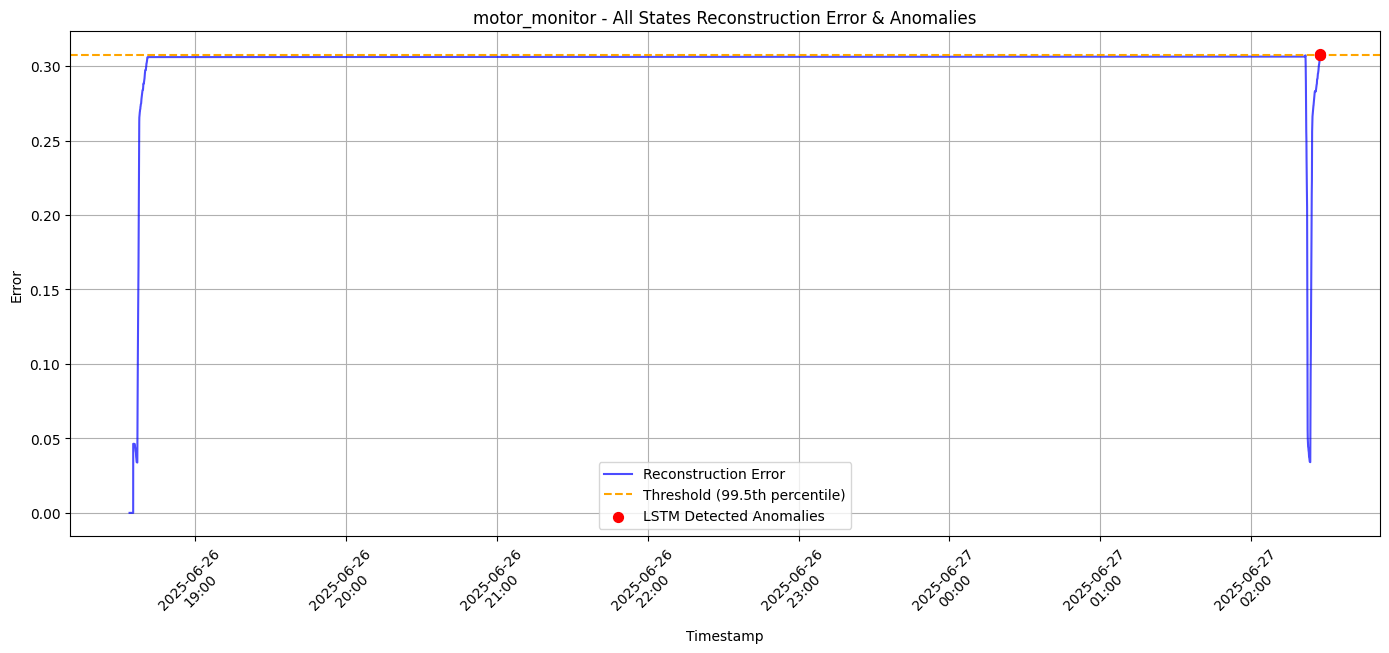

📤 Exported 467 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.93 sec
📤 prediction/anomaly/motor24 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.309721 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    445
True       3
Name: count, dtype: int64


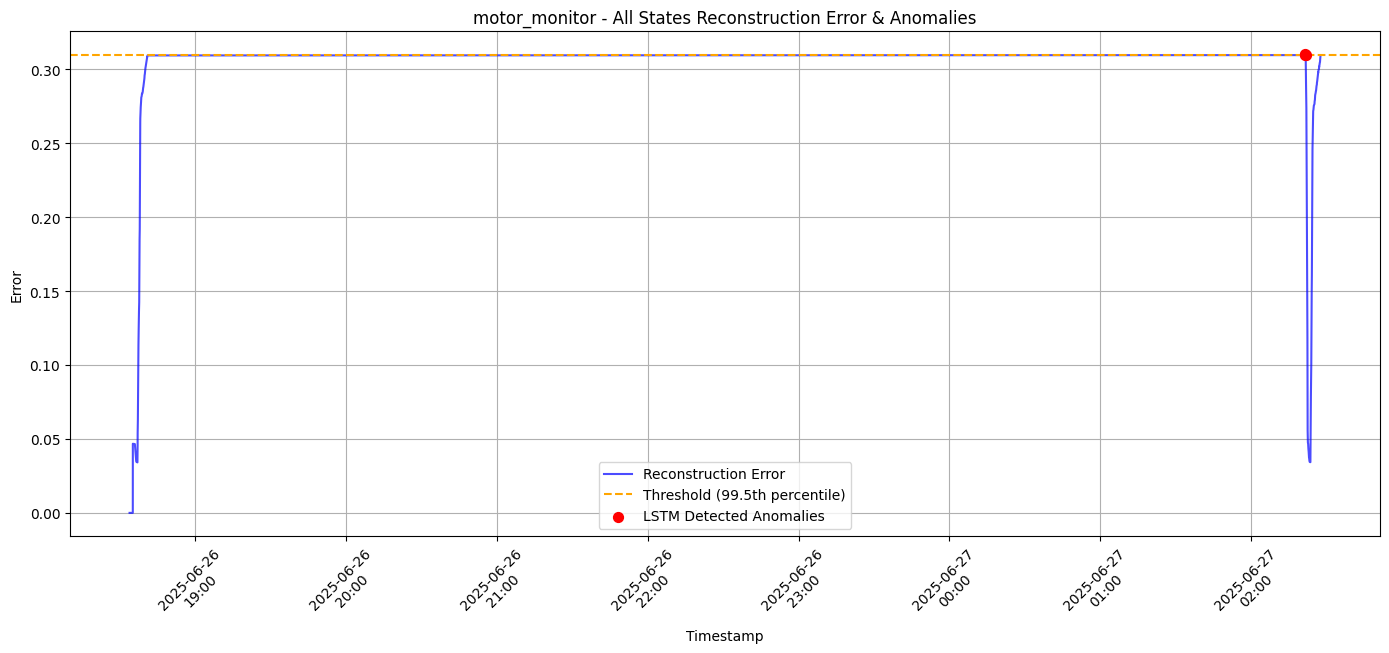

📤 Exported 448 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.96 sec
📤 prediction/anomaly/motor25 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.313432 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    465
True       3
Name: count, dtype: int64


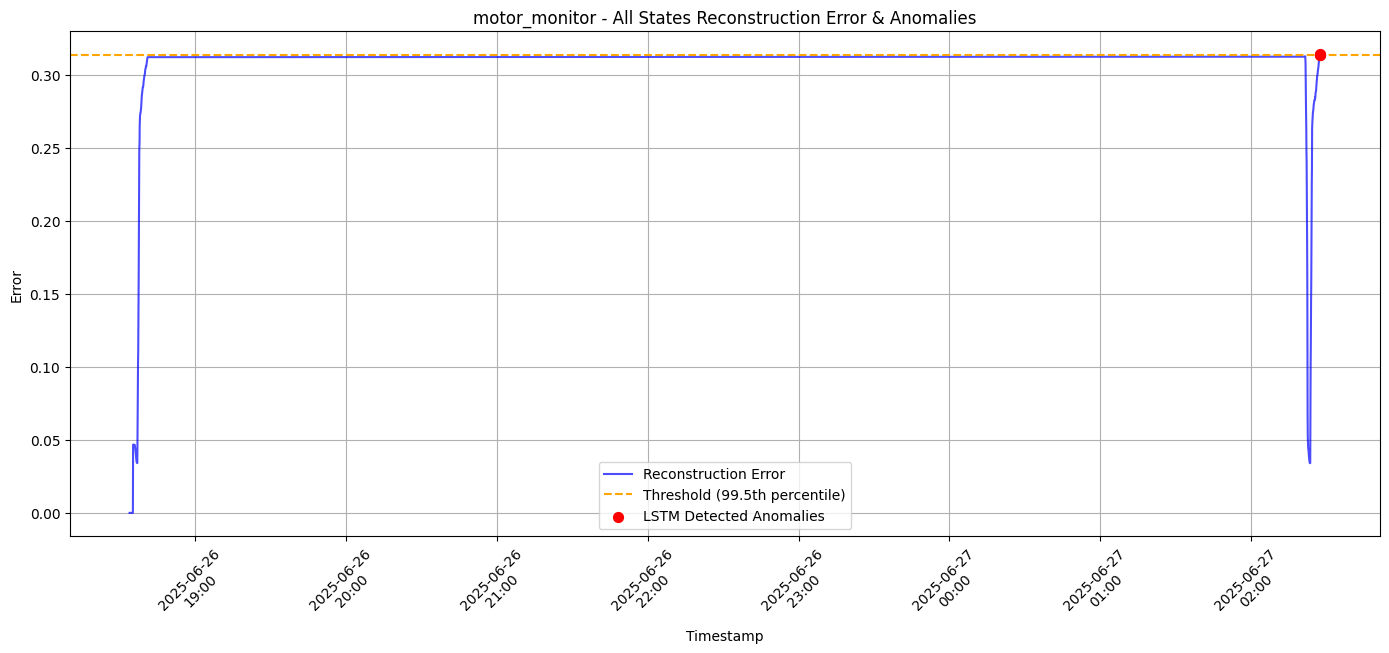

📤 Exported 468 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.88 sec
📤 prediction/anomaly/motor26 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.310991 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    433
True       3
Name: count, dtype: int64


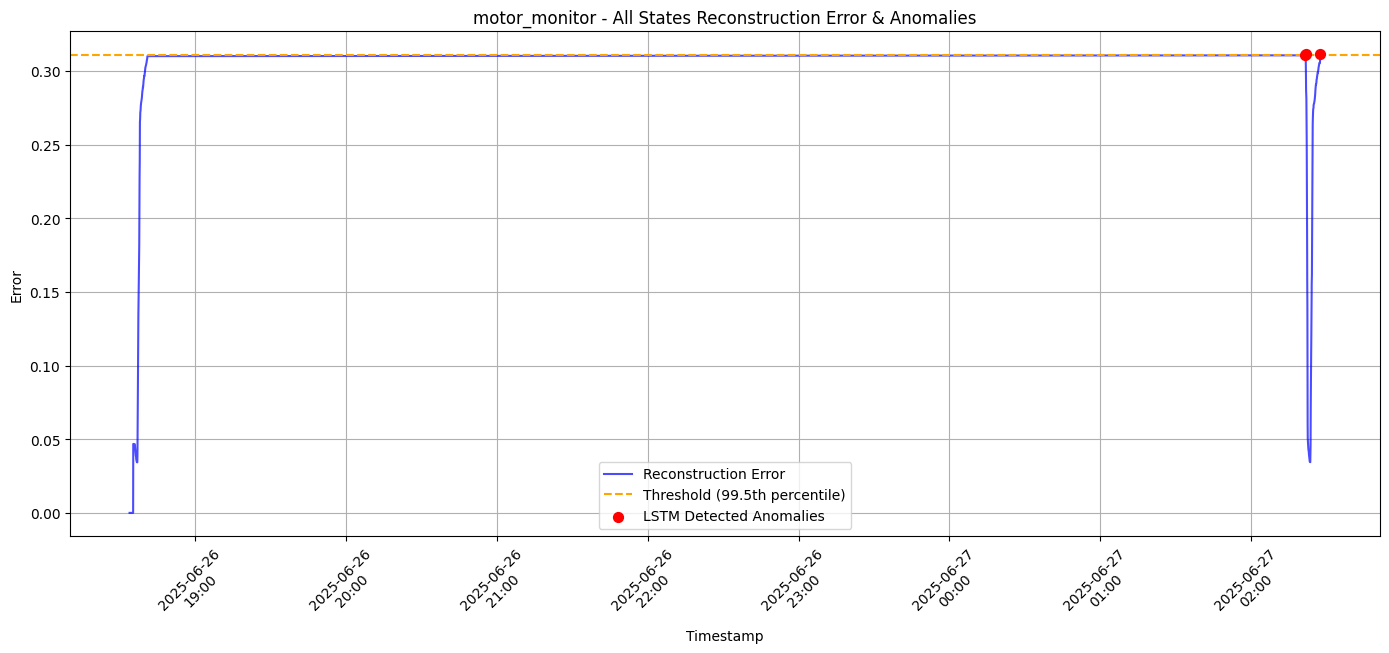

📤 Exported 436 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.88 sec
📤 prediction/anomaly/motor27 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.317064 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    470
True       3
Name: count, dtype: int64


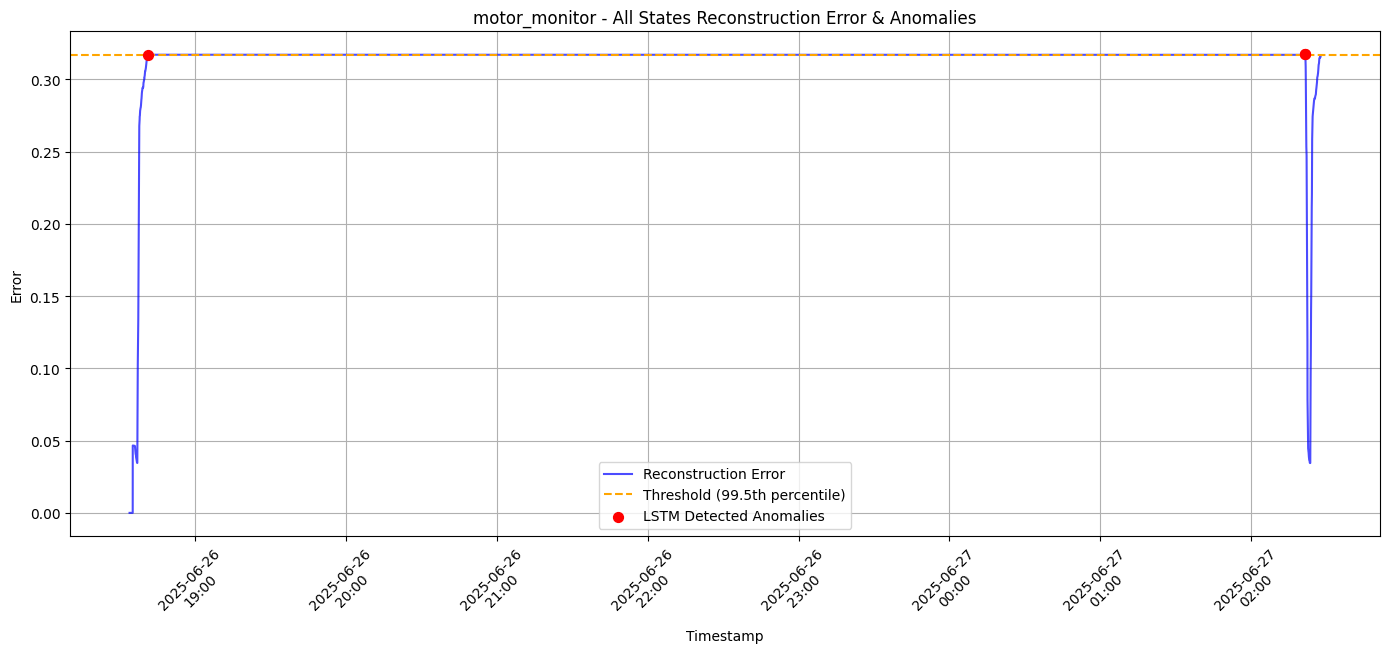

📤 Exported 473 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.96 sec
📤 prediction/anomaly/motor28 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.314697 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    444
True       3
Name: count, dtype: int64


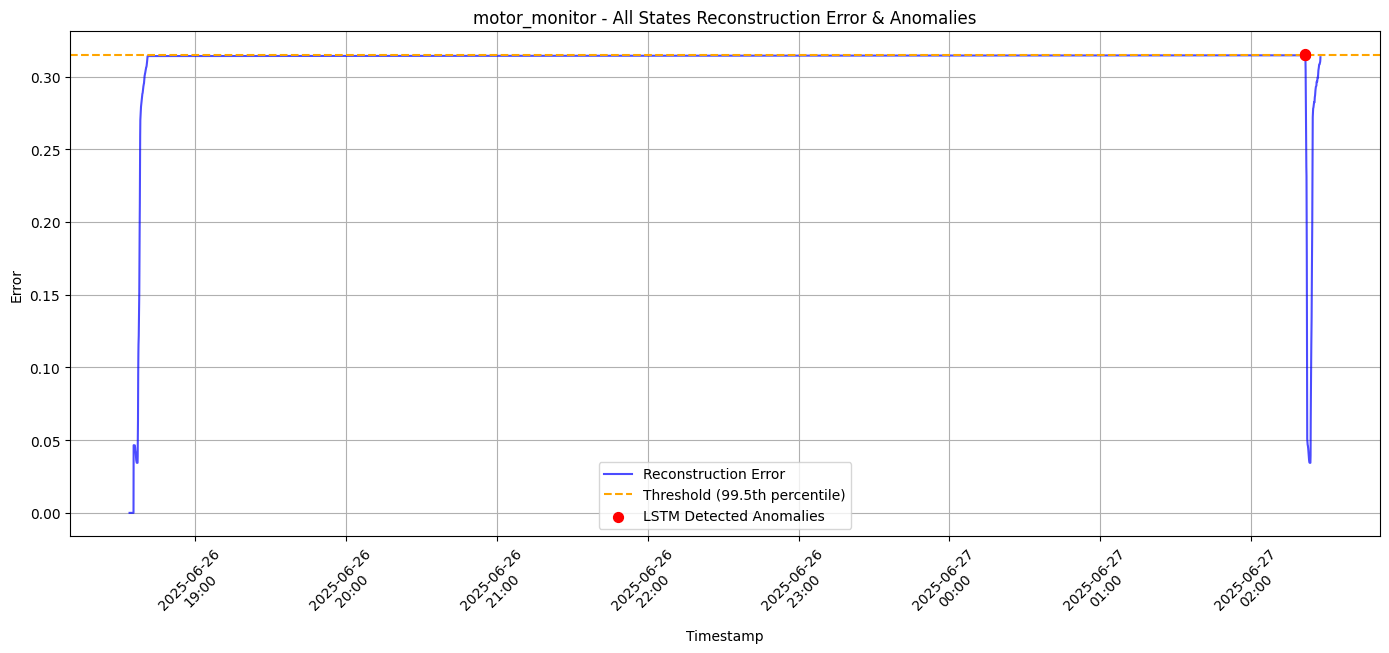

📤 Exported 447 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.24 sec
📤 prediction/anomaly/motor29 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.316147 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    504
True       3
Name: count, dtype: int64


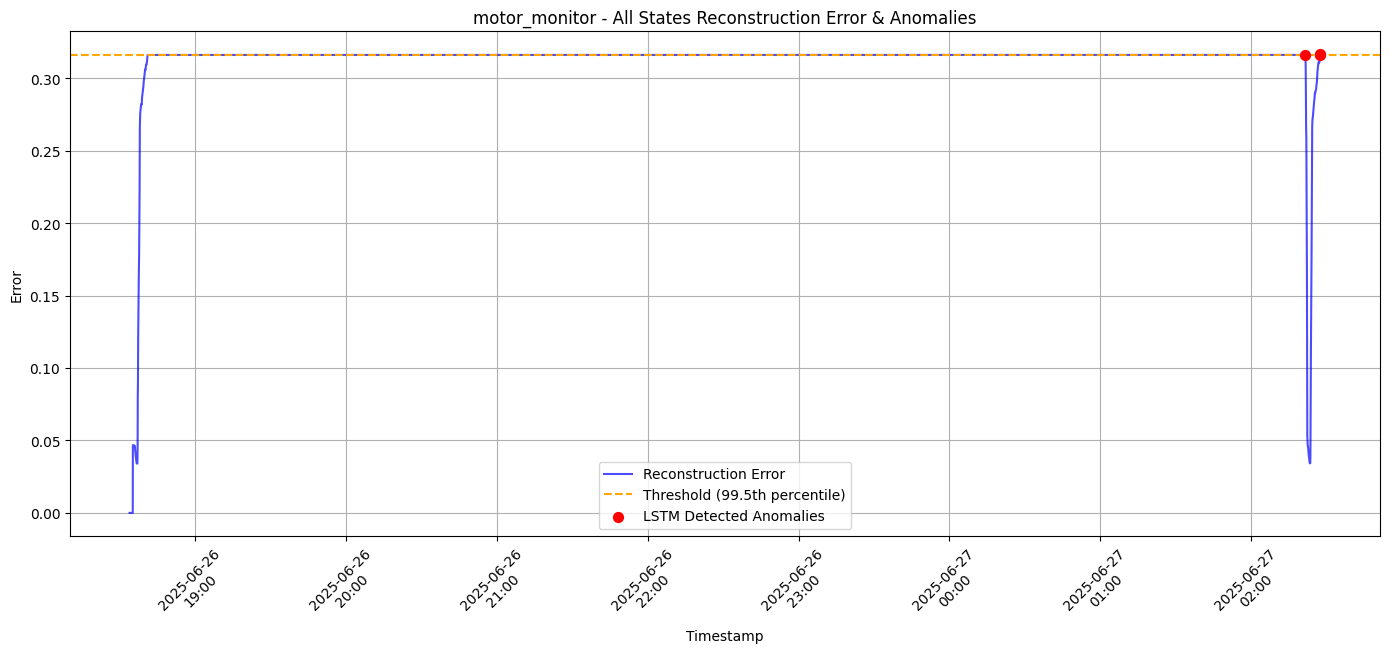

📤 Exported 507 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.96 sec
📤 prediction/anomaly/motor3 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.312074 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    462
True       3
Name: count, dtype: int64


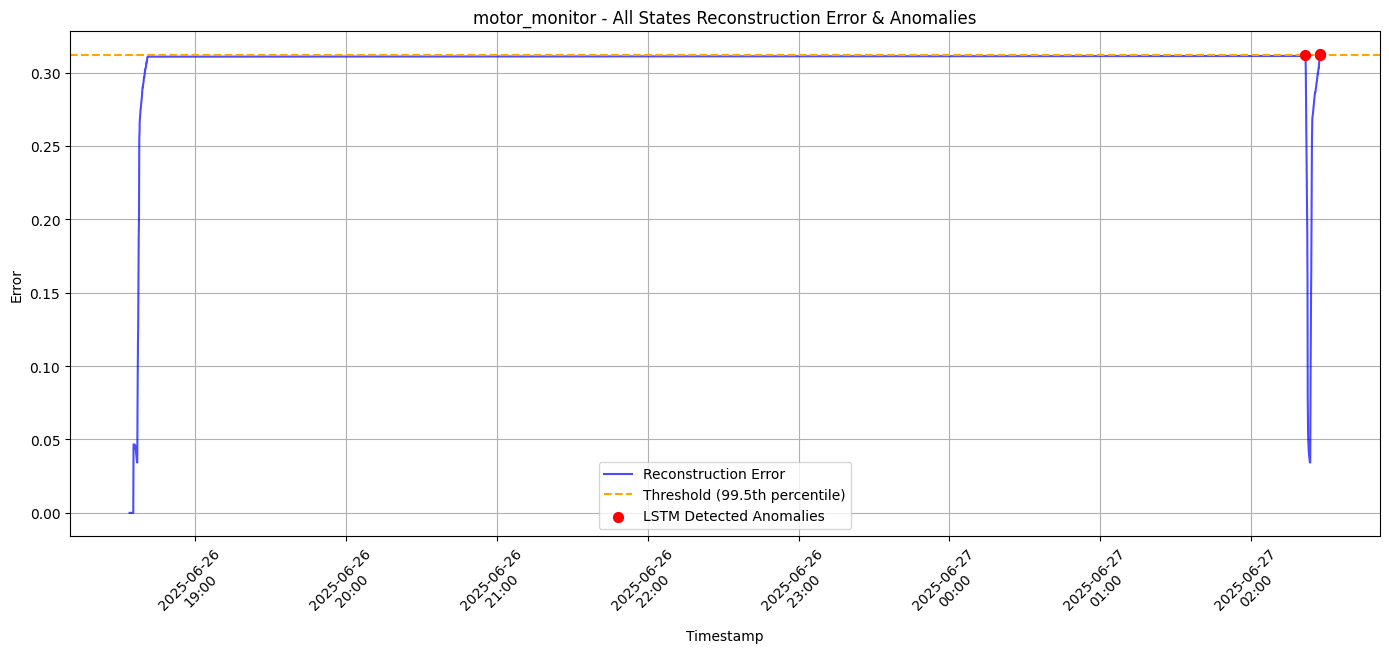

📤 Exported 465 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.92 sec
📤 prediction/anomaly/motor30 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.318146 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    493
True       3
Name: count, dtype: int64


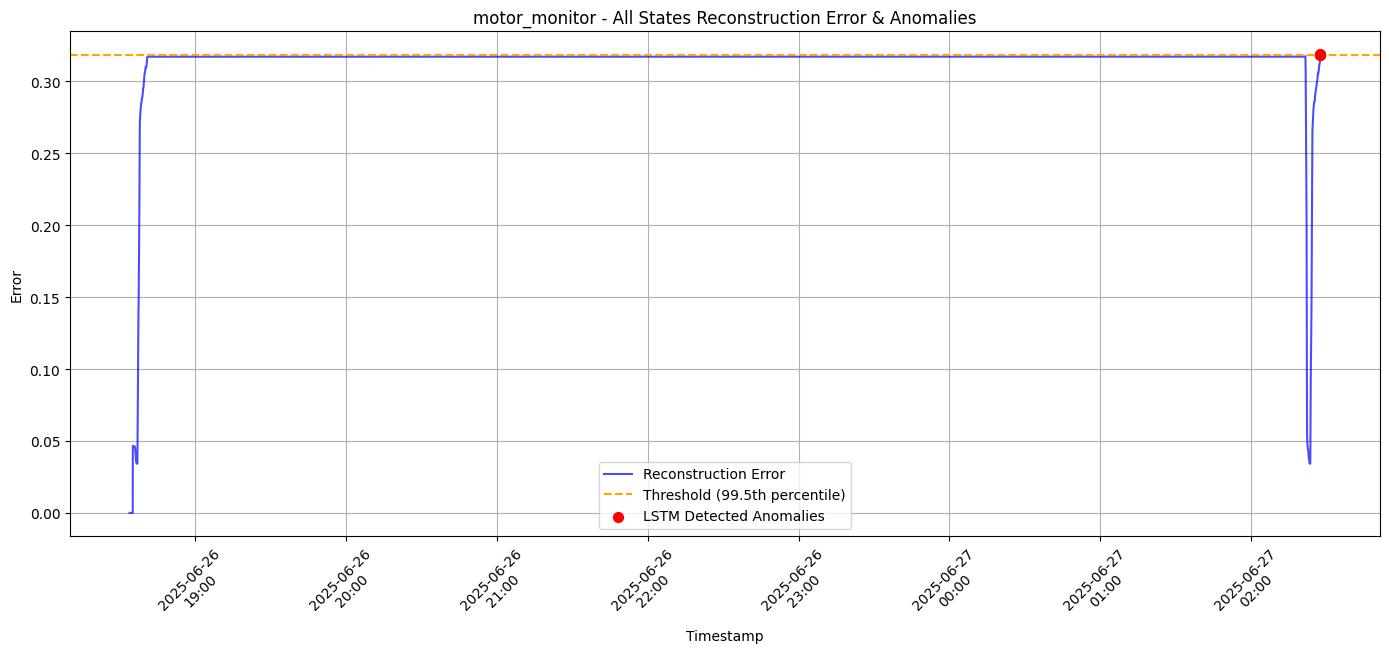

📤 Exported 496 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.91 sec
📤 prediction/anomaly/motor31 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.314188 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    475
True       3
Name: count, dtype: int64


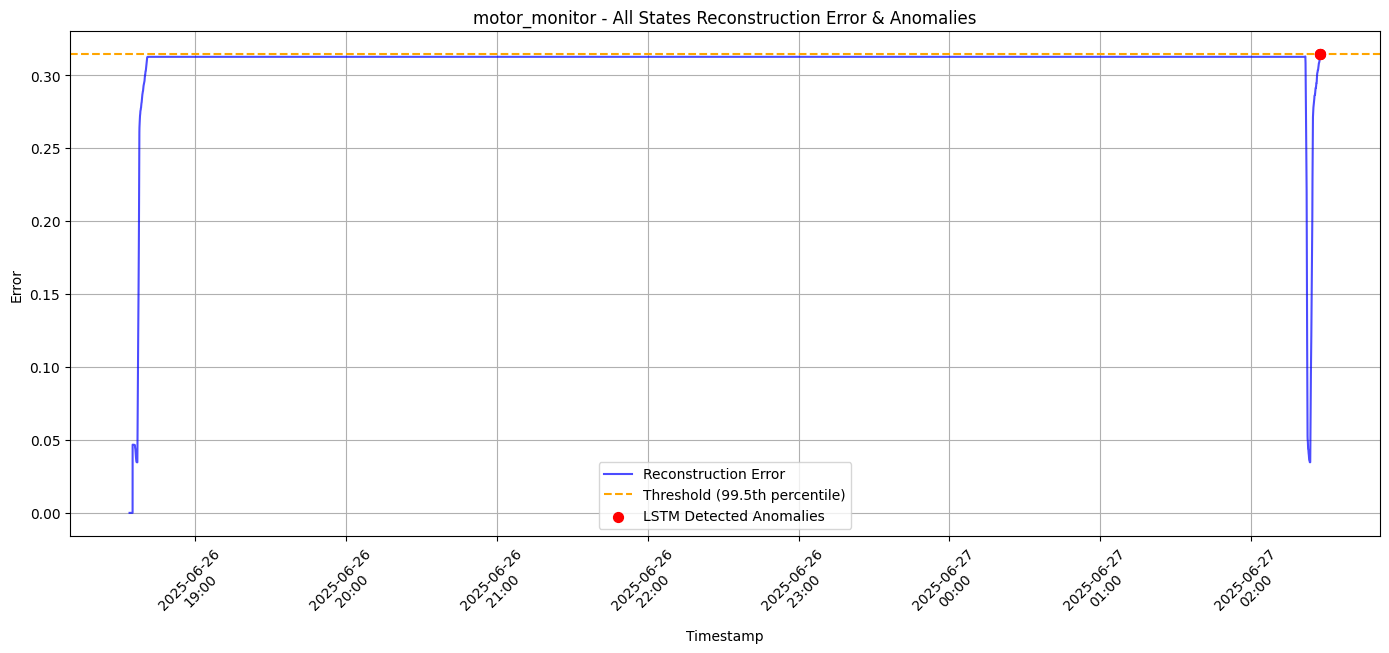

📤 Exported 478 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.70 sec
📤 prediction/anomaly/motor32 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.310967 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    475
True       3
Name: count, dtype: int64


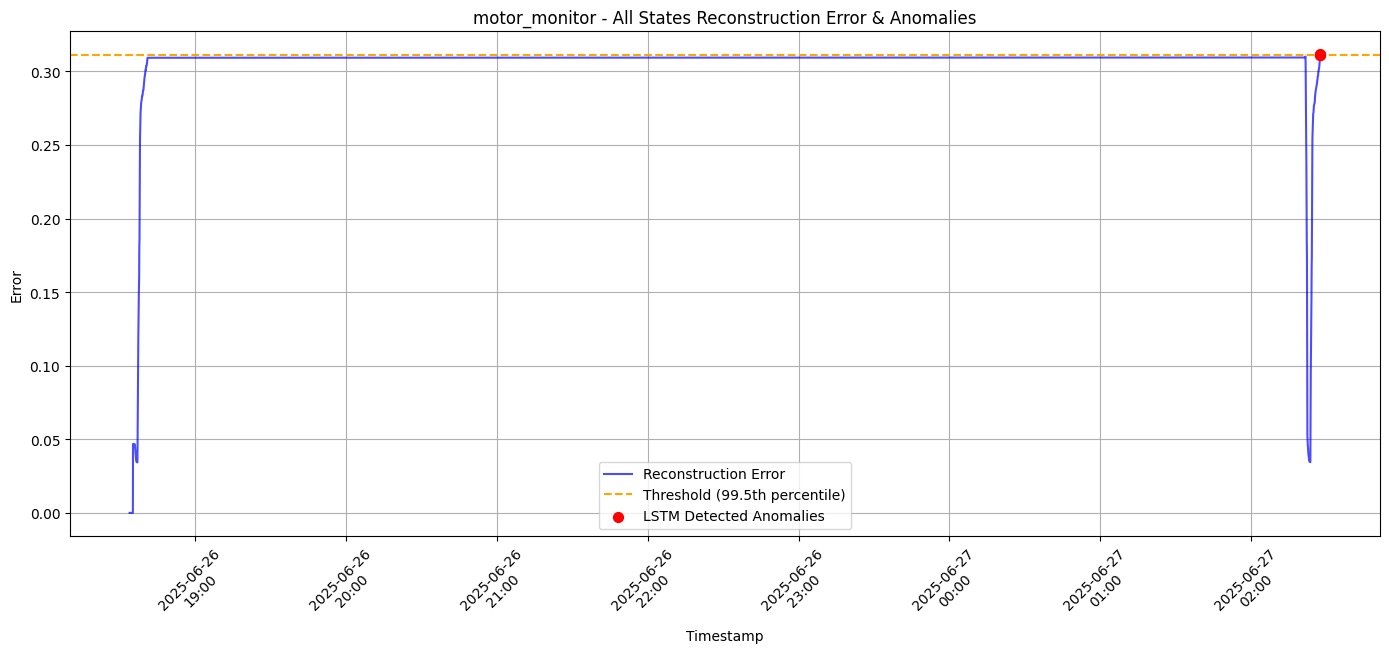

📤 Exported 478 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.74 sec
📤 prediction/anomaly/motor33 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.309091 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    462
True       3
Name: count, dtype: int64


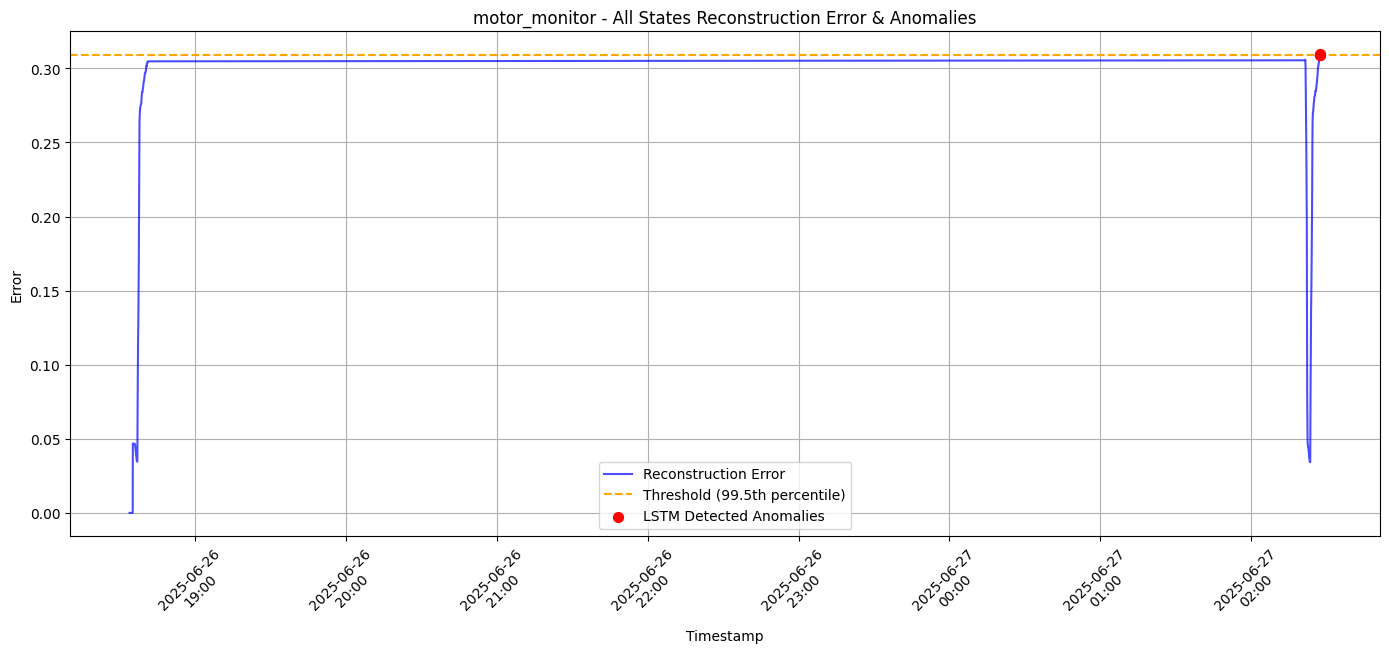

📤 Exported 465 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.88 sec
📤 prediction/anomaly/motor34 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.308703 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    459
True       3
Name: count, dtype: int64


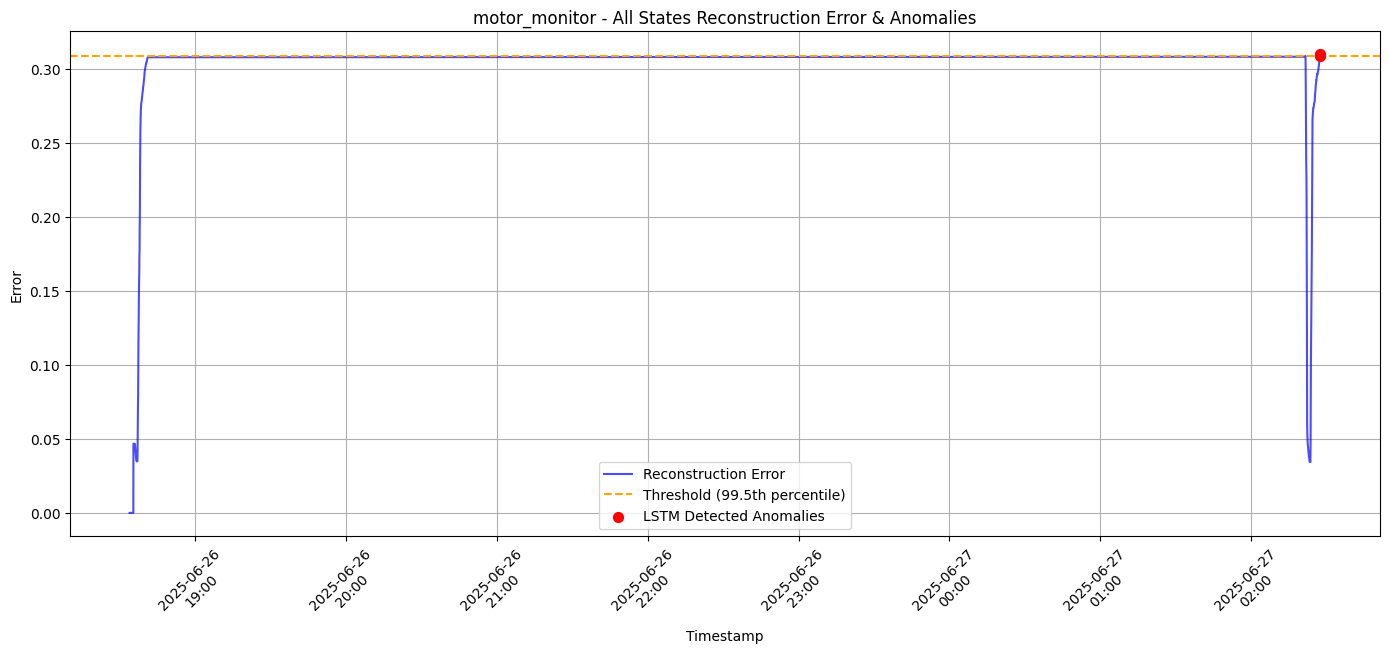

📤 Exported 462 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.92 sec
📤 prediction/anomaly/motor35 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.316147 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    504
True       3
Name: count, dtype: int64


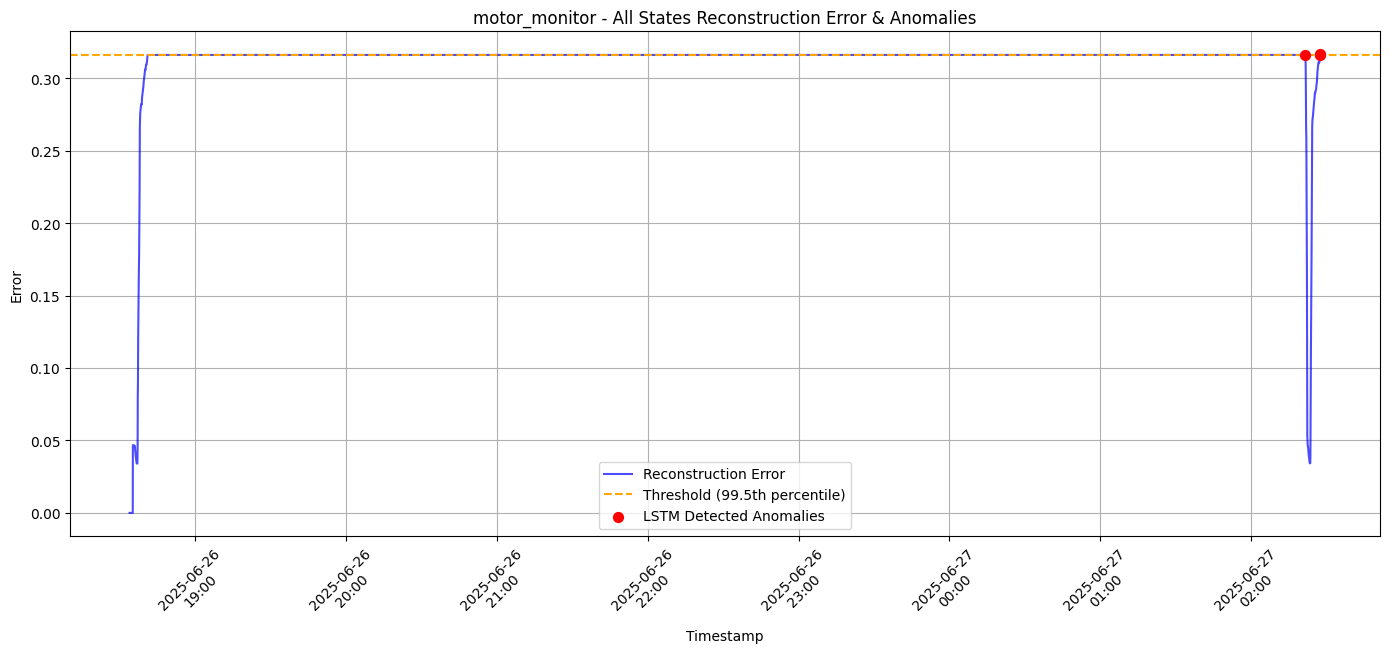

📤 Exported 507 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.28 sec
📤 prediction/anomaly/motor36 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.310361 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    474
True       3
Name: count, dtype: int64


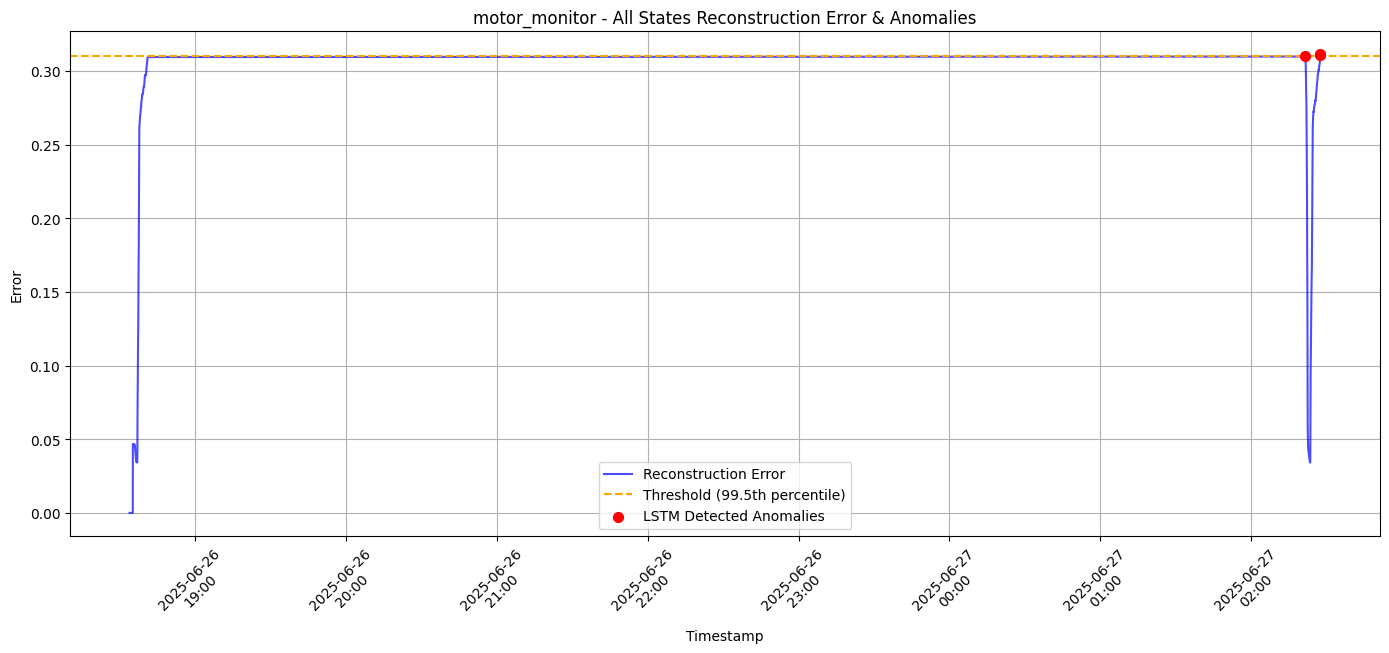

📤 Exported 477 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.93 sec
📤 prediction/anomaly/motor37 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.307025 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    491
True       3
Name: count, dtype: int64


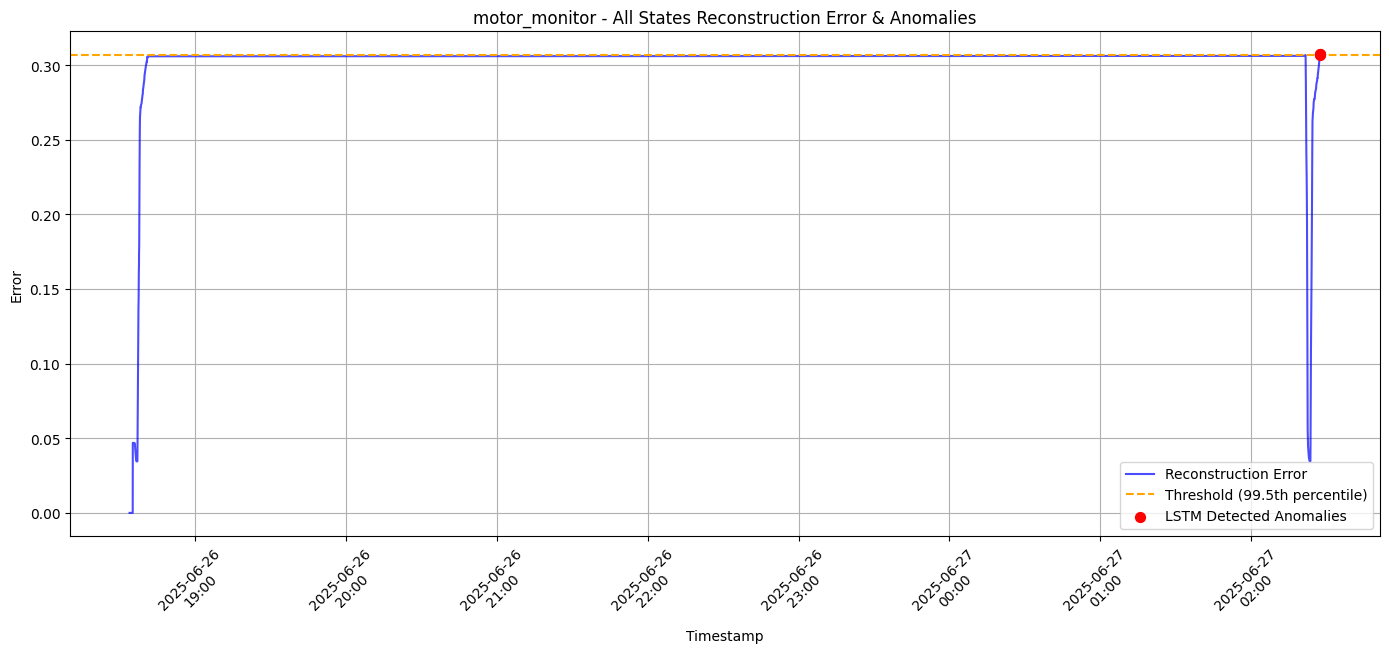

📤 Exported 494 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.94 sec
📤 prediction/anomaly/motor38 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.308327 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    468
True       3
Name: count, dtype: int64


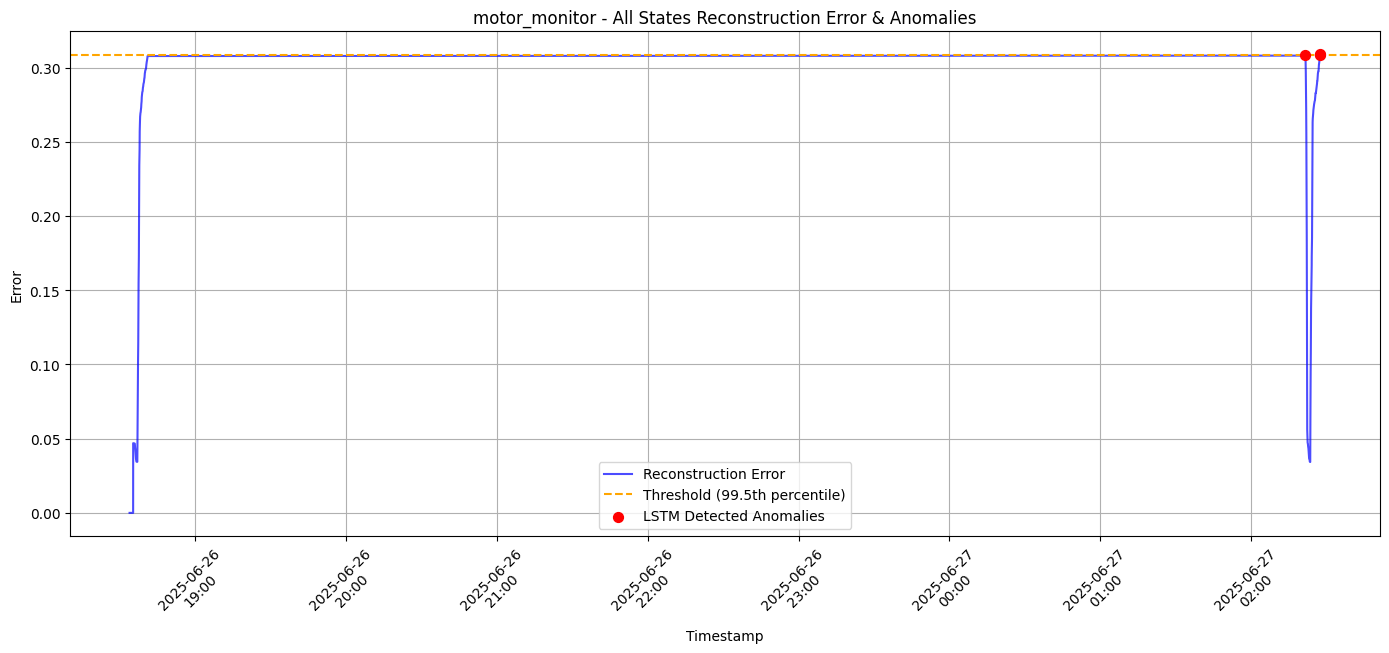

📤 Exported 471 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.95 sec
📤 prediction/anomaly/motor39 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.316585 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    576
True       3
Name: count, dtype: int64


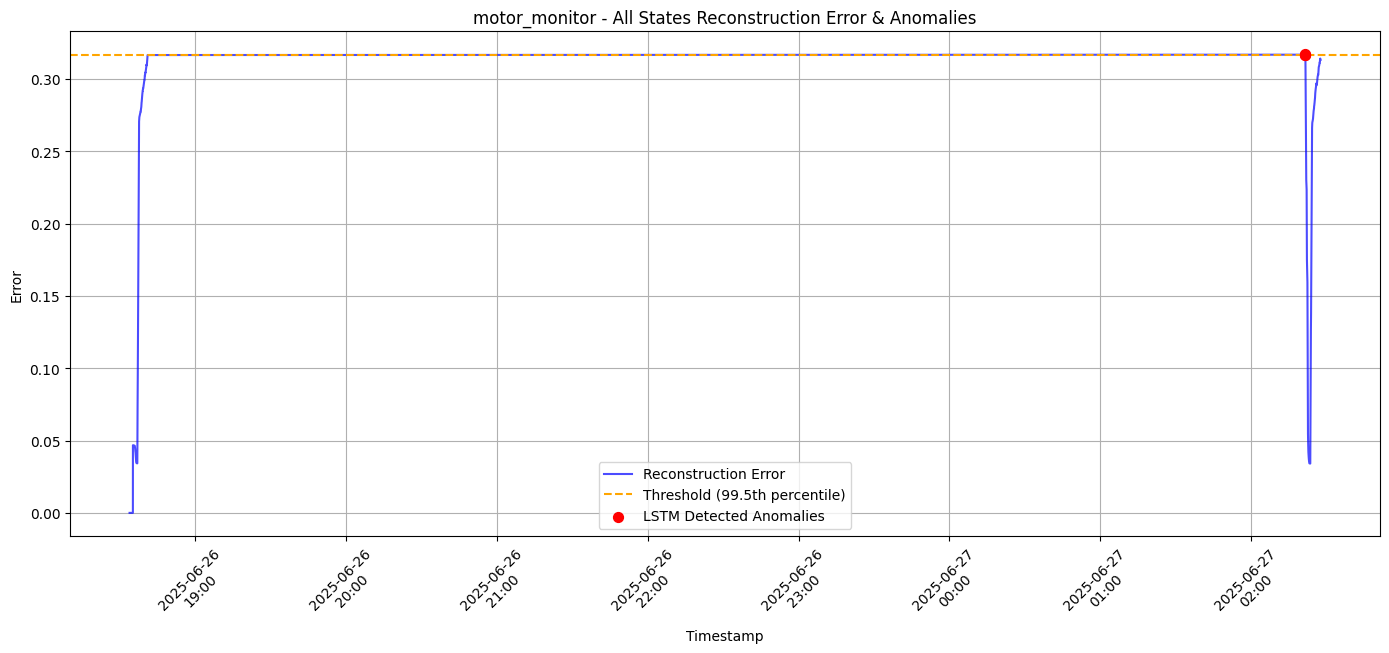

📤 Exported 579 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.01 sec
📤 prediction/anomaly/motor4 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.311403 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    594
True       3
Name: count, dtype: int64


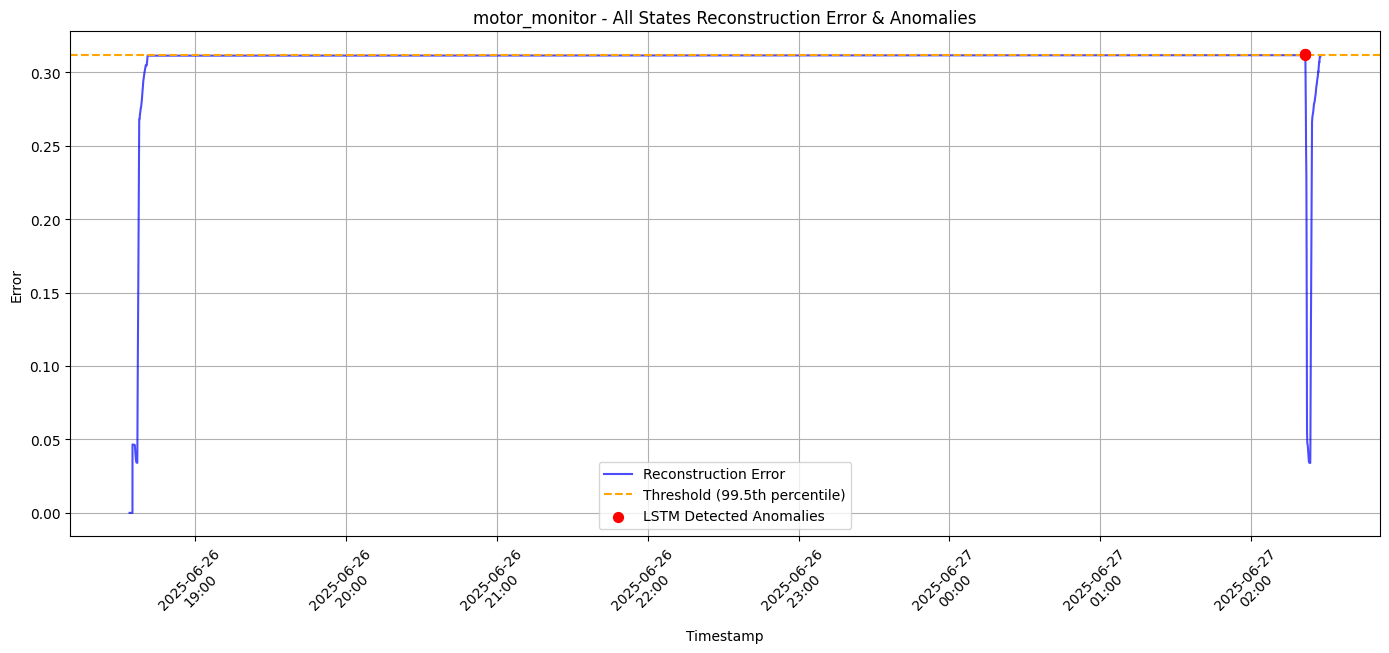

📤 Exported 597 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.98 sec
📤 prediction/anomaly/motor5 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.307917 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    602
True       3
Name: count, dtype: int64


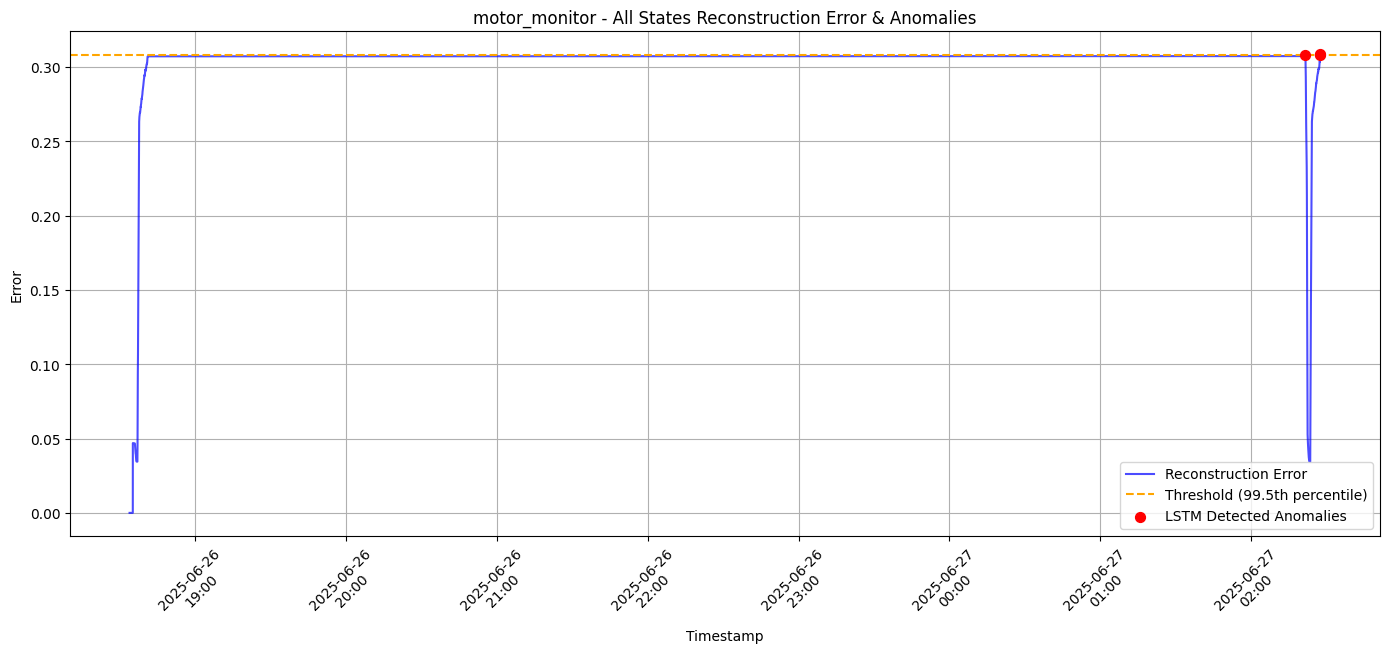

📤 Exported 605 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.03 sec
📤 prediction/anomaly/motor6 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.312904 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    445
True       3
Name: count, dtype: int64


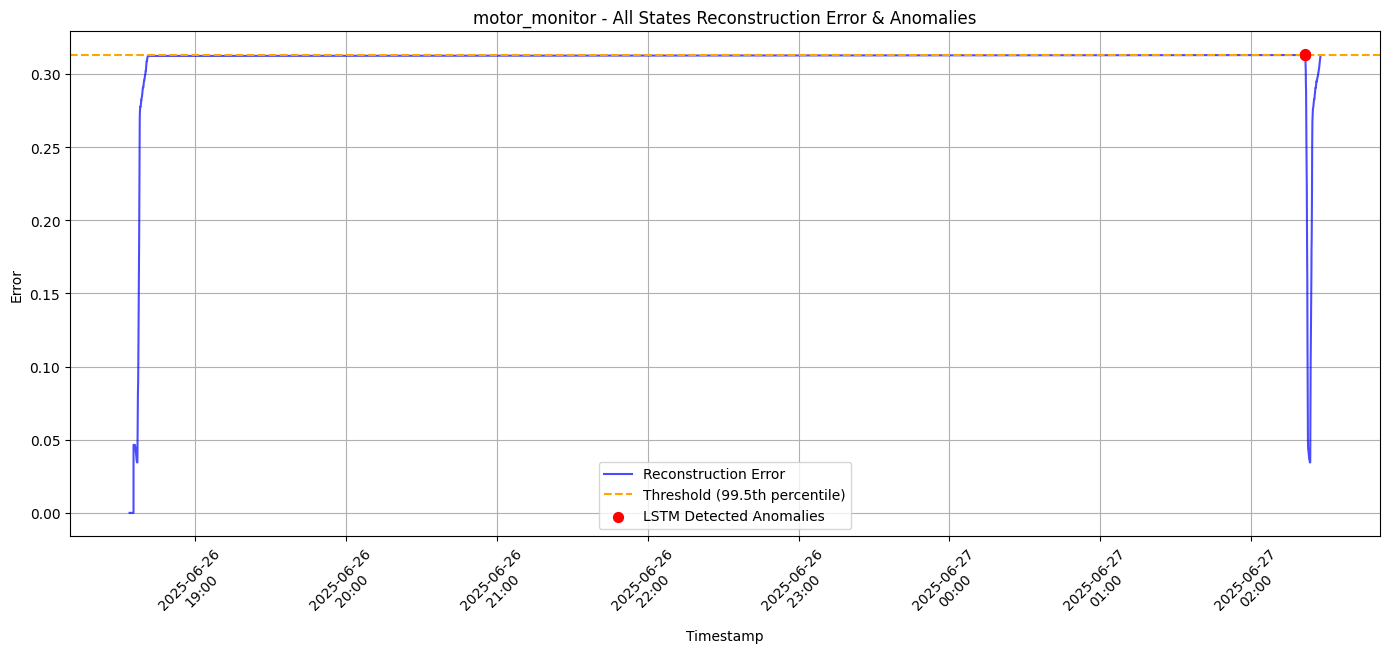

📤 Exported 448 records for motor_monitor to JSON
✅ Finished motor_monitor in 1.44 sec
📤 prediction/anomaly/motor7 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.310075 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    453
True       3
Name: count, dtype: int64


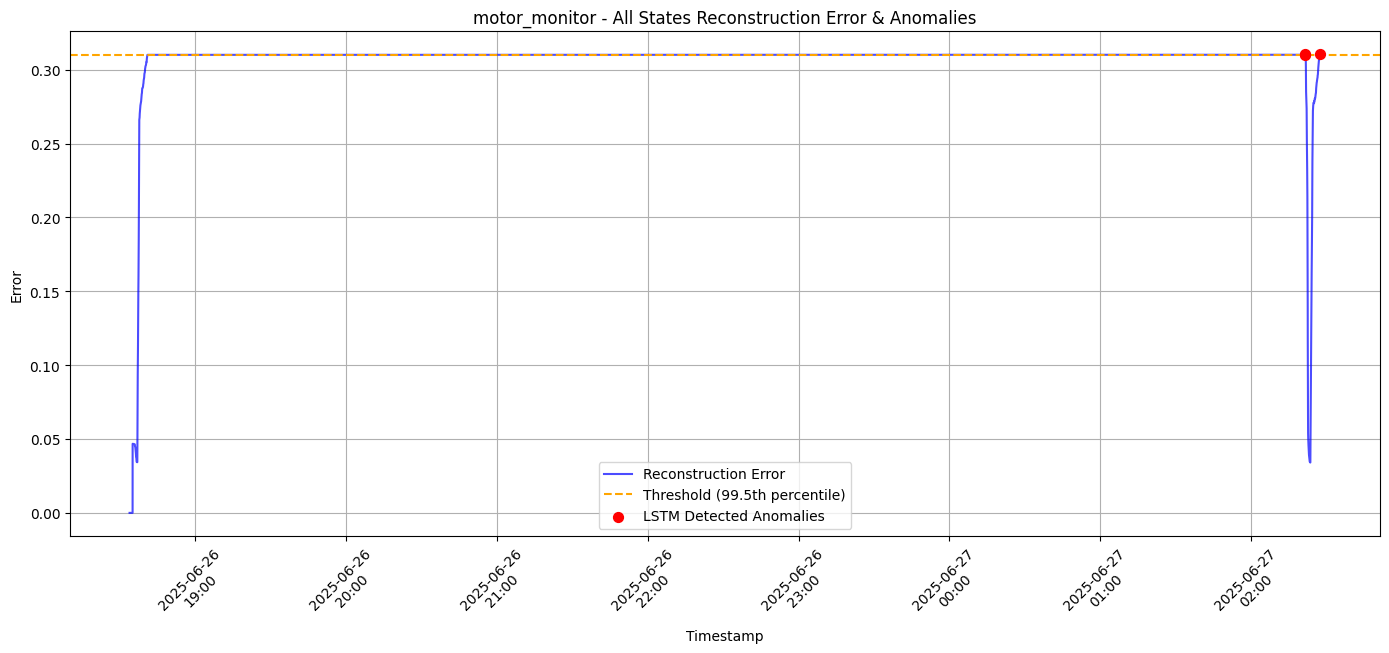

📤 Exported 456 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.94 sec
📤 prediction/anomaly/motor8 sent

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']


/app/src/pipeline/postgres_connection.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Threshold for /app/src/pipeline/../../storage/saved_models/lstm_off.h5: 0.311344 (99.5th percentile)
DEBUG: After thresholding, anomaly_flags unique values: [False  True]
DEBUG: After thresholding, count of True flags: 3

--- DEBUG: motor_monitor is_anomaly counts BEFORE JSON export ---
is_anomaly
False    490
True       3
Name: count, dtype: int64


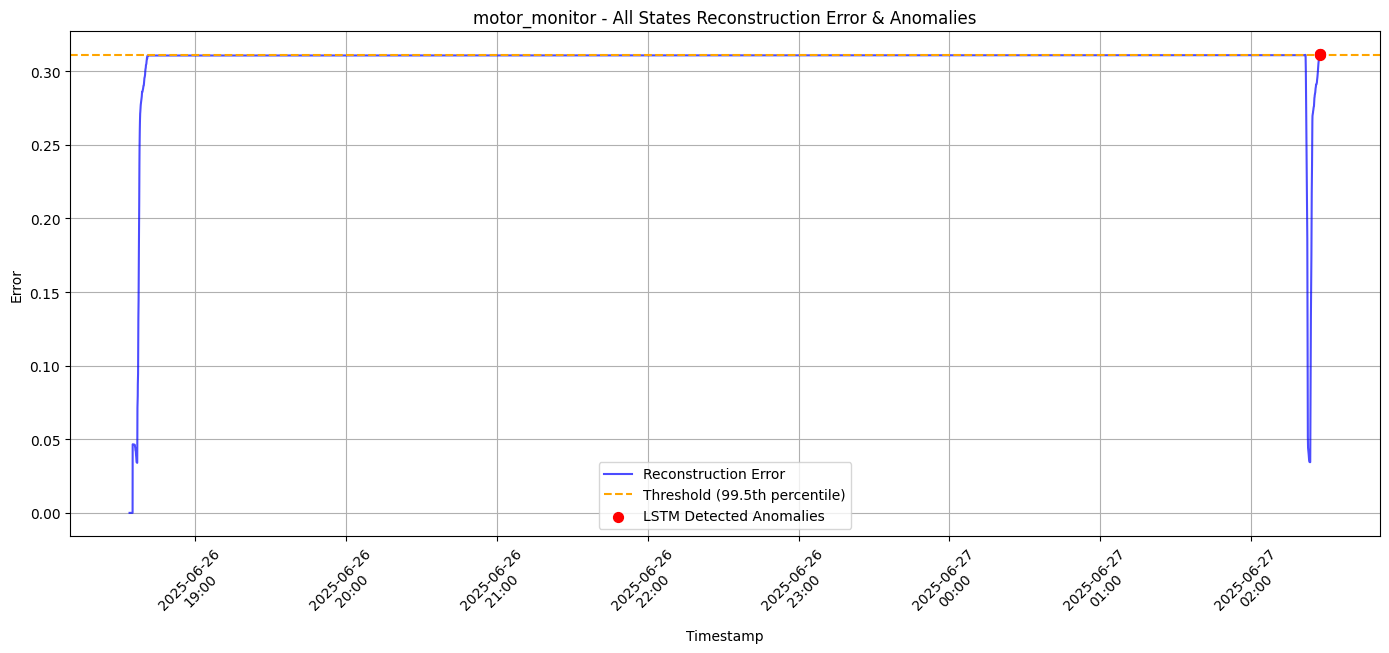

📤 Exported 493 records for motor_monitor to JSON
✅ Finished motor_monitor in 0.95 sec
📤 prediction/anomaly/motor9 sent


In [4]:
# --- Main execution flow ---
mode = "query"  # Change to "csv" for CSV processing, "query" for database query

if mode == "csv":
    device_files = get_device_files()
    all_results = {}

    for device_type, csv_file_path in device_files: # get_device_files now returns full_path
        result = process_device(device_type, csv_file_path)
        if result is not None:
            all_results[device_type] = result

    # Removed RF training loop as RF classifier is being removed from AD repo
    # for device_name, df_result in all_results.items():
    #     train_rf_for_device(device_name, df_result)

    import time # Re-import time if needed for global_end_time

    global_end_time = time.time()

    end_memory = process.memory_info().rss / (1024 * 1024)

    print("\n✅ ALL DEVICES PROCESSED")
    print(f"⏱️ Total Time: {global_end_time - global_start_time:.2f} sec")
    print(f"💾 Start Memory: {start_memory:.2f} MB")
    print(f"💾 End Memory: {end_memory:.2f} MB")
    print(f"📈 Memory Growth: {end_memory - start_memory:.2f} MB")

elif mode == "query":
    # Connect to PostgreSQL
    conn = pg_conn.get_postgres_connection()
    motor_list = pg_conn.get_all_motor_names(conn)

    # Initialize MQTT client
    mqtt_client = mqtt.Client(client_id="prediction-publisher")
    mqtt_client.connect("hivemq", 1883, 60)  # use "localhost" if running locally

    for motor_name in motor_list:
        timeseries = pg_conn.get_motor_timeseries(conn, motor_name)
        result = process_device_query("motor_monitor", timeseries)
        
        if result is not None:
            topic = f"prediction/anomaly/{motor_name}"
            payload = json.dumps({
                "motor": motor_name,
                "result": json.loads(result.to_json(orient='records', date_format="iso")) 
            })
            mqtt_client.publish(topic, payload)
            print(f"📤 {topic} sent")

    mqtt_client.disconnect()
    conn.close()


In [ ]:
test_output = json.loads(result.to_json(orient='records', date_format="iso"))  # Convert DataFrame to JSON format
print(test_output[1])  # Print the JSON output for verification